## OCNT-DMSLIB-0 MC4R Gs/Gq Bias

We have three concentrations each of aMSH and THIQ in each of the Gs and Gq reporter systems, but not precisely the same concentrations. We also have a None condition in both systems, and Forskolin in Gs only. We generated Unnormalized summary statistics within each condition, and then can create the following concentration pairings between Gs and Gq:

| Comparison | Gs Concentration | Gq Concentration | 
| --- | ----------- | ----- |
| None | 0 | 0 |
| Low aMSH | 5e-10 | 2e-08 |
| Med aMSH | 5e-09 | 5e-08 |
| High aMSH | 2e-08 | 1e-06 |
| Low THIQ | 4e-10 | 3e-09 |
| Med THIQ | 4e-09 | 9e-09 |
| High THIQ | 1.2e-08 | 1e-07 | 

We compute each of these contrasts and examine the results below.

1. [Summary Statistics](#part1)
2. [Heatmaps](#part2)
3. [Biased Positions and Variants](#part3)
4. [Medium Comparisons](#part4)

### Summary Statistics <a name="part1"></a>

To get an initial intuition for the relationship between the summary statistics we have from Gs and Gq, we can plot the Z-statistics per variant from either dataset on the same plot, startified by the pairings defined above.

In [115]:
library(ggpubr)
library(ggside)
library(scico)
library(ggbeeswarm)
library(scales)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

In [3]:
pairings_gs <- tibble("condition" = c("None0", "aMSH5e-10", "aMSH5e-09", "aMSH2e-08",
                                   "THIQ4e-10", "THIQ4e-09", "THIQ1.2e-08"),
                    "drug" = c("None", rep("aMSH", 3), rep("THIQ", 3)),
                    "level" = c("None", rep(c("Low", "Med", "High"), 2)),
                     "pathway" = "Gs")

pairings_gq <- tibble("condition" = c("None0", "aMSH2e-08", "aMSH5e-08", "aMSH1e-06",
                                   "THIQ3e-09", "THIQ9e-09", "THIQ1e-07"),
                   "drug" = c("None", rep("aMSH", 3), rep("THIQ", 3)),
                   "level" = c("None", rep(c("Low", "Med", "High"), 2)),
                     "pathway" = "Gq")

pairings <- bind_rows(pairings_gs, pairings_gq)

In [4]:
sumstats_gs <- read_tsv("../sumstats/MC4R/MC4R-DMS5-Gs-unnormalized.tsv") %>%
    mutate("pathway" = "Gs")
sumstats_gq <- read_tsv("../sumstats/MC4R/MC4R-DMS8-Gq-unnormalized.tsv") %>%
    mutate("pathway" = "Gq")

sumstats <- bind_rows(sumstats_gs, sumstats_gq) %>%
    filter(condition != "Forsk2.5e-05") %>%
    left_join(pairings, by = c("condition", "pathway")) %>%
    mutate(condition = paste0(pathway, "_", drug, "_", level))

Rows: 53064 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): condition, aa, version, group
dbl (7): pos, chunk, estimate, std.error, statistic, p.value, dispersion
lgl (1): clone

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 46431 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): condition, aa, version, group
dbl (7): pos, chunk, estimate, std.error, statistic, p.value, dispersion
lgl (1): clone

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


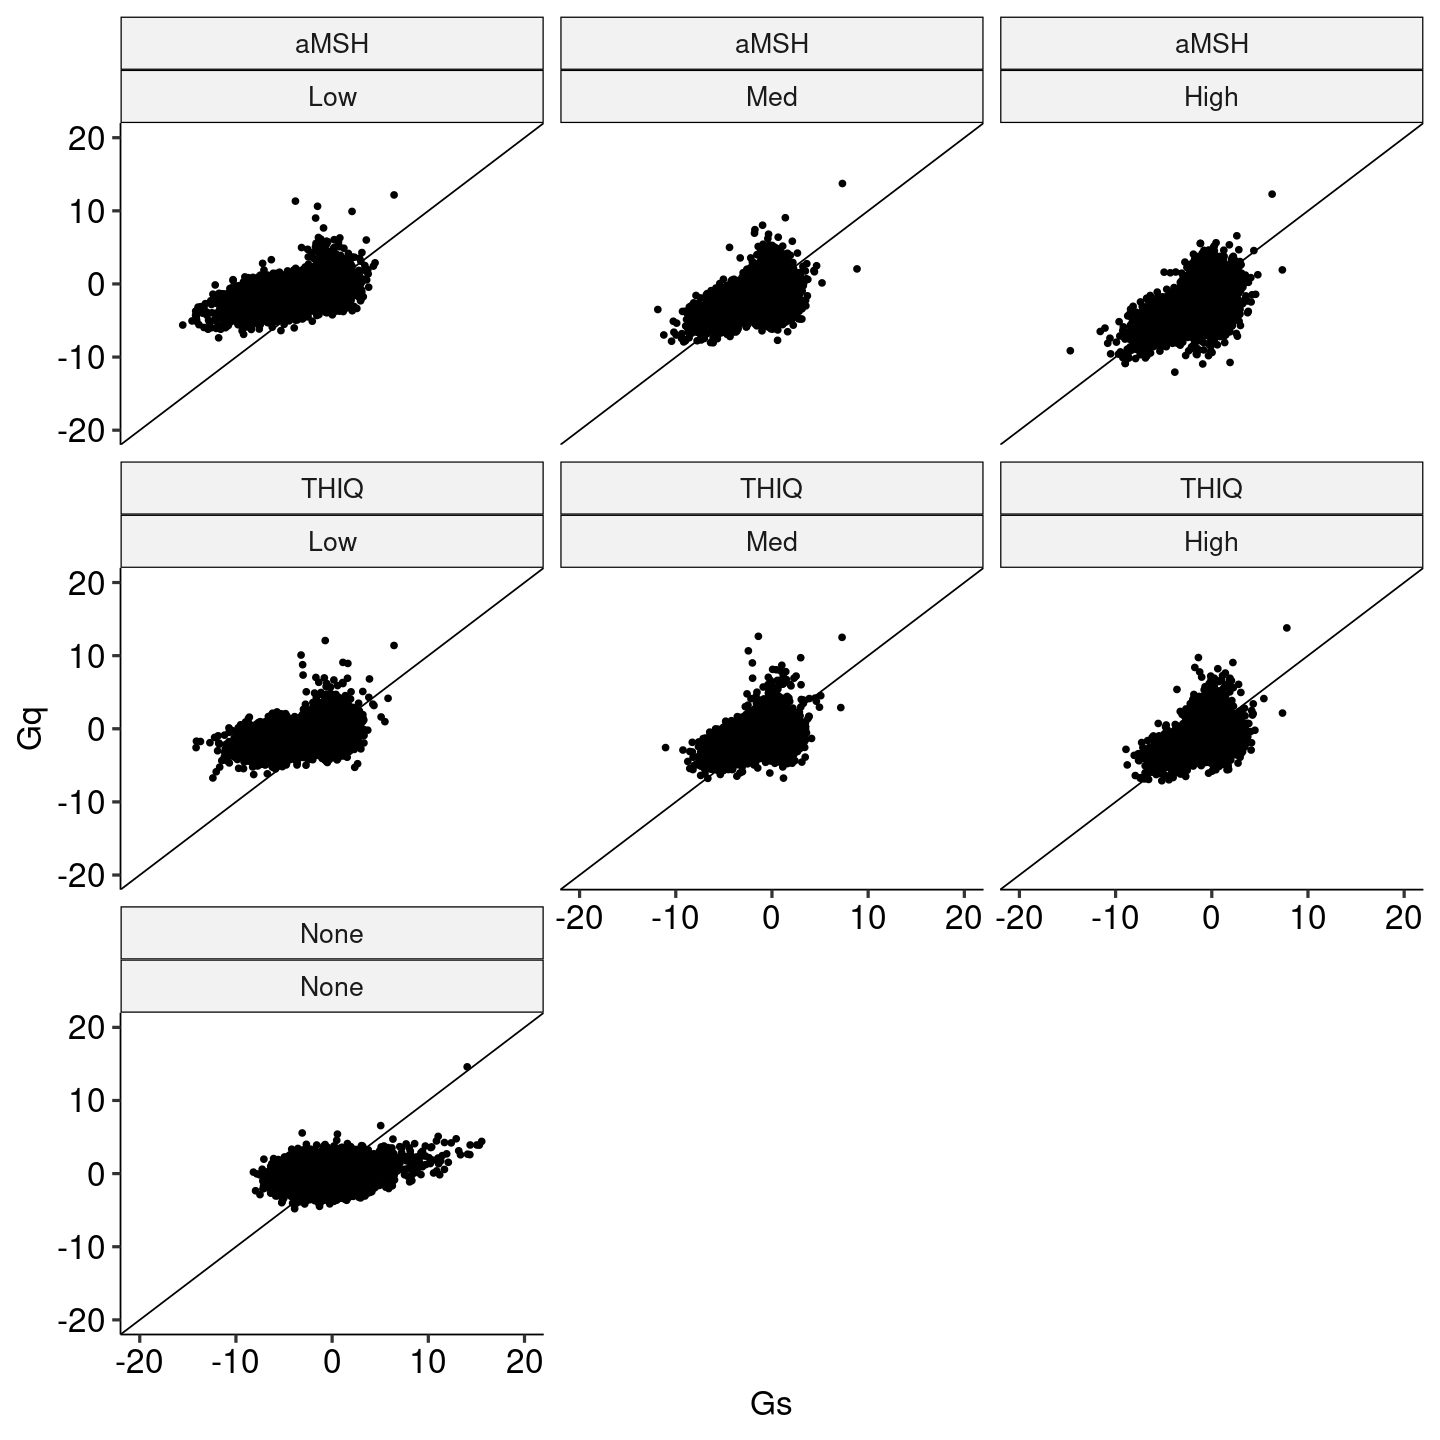

In [6]:
options(repr.plot.width = 12, repr.plot.height = 12)
z_stat_compare <- sumstats %>%
    select(pos, aa, statistic, pathway, drug, level) %>%
    pivot_wider(names_from = pathway, values_from = statistic) %>%
    mutate(drug = factor(drug, levels = c("aMSH", "THIQ", "None")),
           level = factor(level, levels = c("Low", "Med", "High", "None")))

ggplot(z_stat_compare) +
    geom_point(aes(x = Gs, y = Gq)) +
    theme_pubr(base_size = 20) +
    xlim(c(-20, 20)) + ylim(c(-20, 20)) +
    facet_wrap(~drug + level, nrow = 3) +
    geom_abline(slope = 1, intercept = 0)

We actually want to compute these differences, and then test for a significant effect at our typical thesholds of 1% and 5% FDR. Those results are now stored in the file called `MC4R-Bias.tsv` located [here](../sumstats/MC4R). We with our other contrast models, they seem fairly well calibrated:

In [7]:
compute_difference <- function(test, control, sumstats) {
    
    df1 <- sumstats %>% filter(condition == test) %>% select(-condition)
    df2 <- sumstats %>% filter(condition == control) %>% select(-condition)
    
    df <- inner_join(df1, df2,
                     by = c("pos", "clone", "chunk", "aa", "version"))
    
    new_stats <- df %>%
        mutate(estimate = estimate.x - estimate.y,
               std.error = sqrt(std.error.x^2 + std.error.y^2)) %>%
        select(pos, clone, chunk, aa, estimate, std.error, version) %>%
        ungroup()
    
    new_stats$condition = paste0(test, " - ", control)
    
    return(new_stats)
    
}

In [8]:
sumstats_bias <- map2_dfr(.x = c("Gs_aMSH_High", "Gs_aMSH_Med", "Gs_aMSH_Low",
                "Gs_THIQ_High", "Gs_THIQ_Med", "Gs_THIQ_Low", "Gs_None_None"),
         .y = c("Gq_aMSH_High", "Gq_aMSH_Med", "Gq_aMSH_Low",
                "Gq_THIQ_High", "Gq_THIQ_Med", "Gq_THIQ_Low", "Gq_None_None"),
         .f = compute_difference, sumstats = sumstats) %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"),
           condition = factor(condition, levels = c("Gs_aMSH_Low - Gq_aMSH_Low",
                                                    "Gs_aMSH_Med - Gq_aMSH_Med",
                                                    "Gs_aMSH_High - Gq_aMSH_High",
                                                    "Gs_None_None - Gq_None_None",
                                                    "Gs_THIQ_Low - Gq_THIQ_Low",
                                                    "Gs_THIQ_Med - Gq_THIQ_Med",
                                                    "Gs_THIQ_High - Gq_THIQ_High")))

sumstats_bias_rev <- map2_dfr(.x = c("Gs_aMSH_High", "Gs_aMSH_Med", "Gs_aMSH_Low",
                "Gs_THIQ_High", "Gs_THIQ_Med", "Gs_THIQ_Low", "Gs_None_None"),
         .y = c("Gq_aMSH_Low", "Gq_aMSH_Med", "Gq_aMSH_High",
                "Gq_THIQ_Low", "Gq_THIQ_Med", "Gq_THIQ_High", "Gq_None_None"),
         .f = compute_difference, sumstats = sumstats) %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"),
           condition = factor(condition, levels = c("Gs_aMSH_Low - Gq_aMSH_High",
                                                    "Gs_aMSH_Med - Gq_aMSH_Med",
                                                    "Gs_aMSH_High - Gq_aMSH_Low",
                                                    "Gs_None_None - Gq_None_None",
                                                    "Gs_THIQ_Low - Gq_THIQ_High",
                                                    "Gs_THIQ_Med - Gq_THIQ_Med",
                                                    "Gs_THIQ_High - Gq_THIQ_Low")))

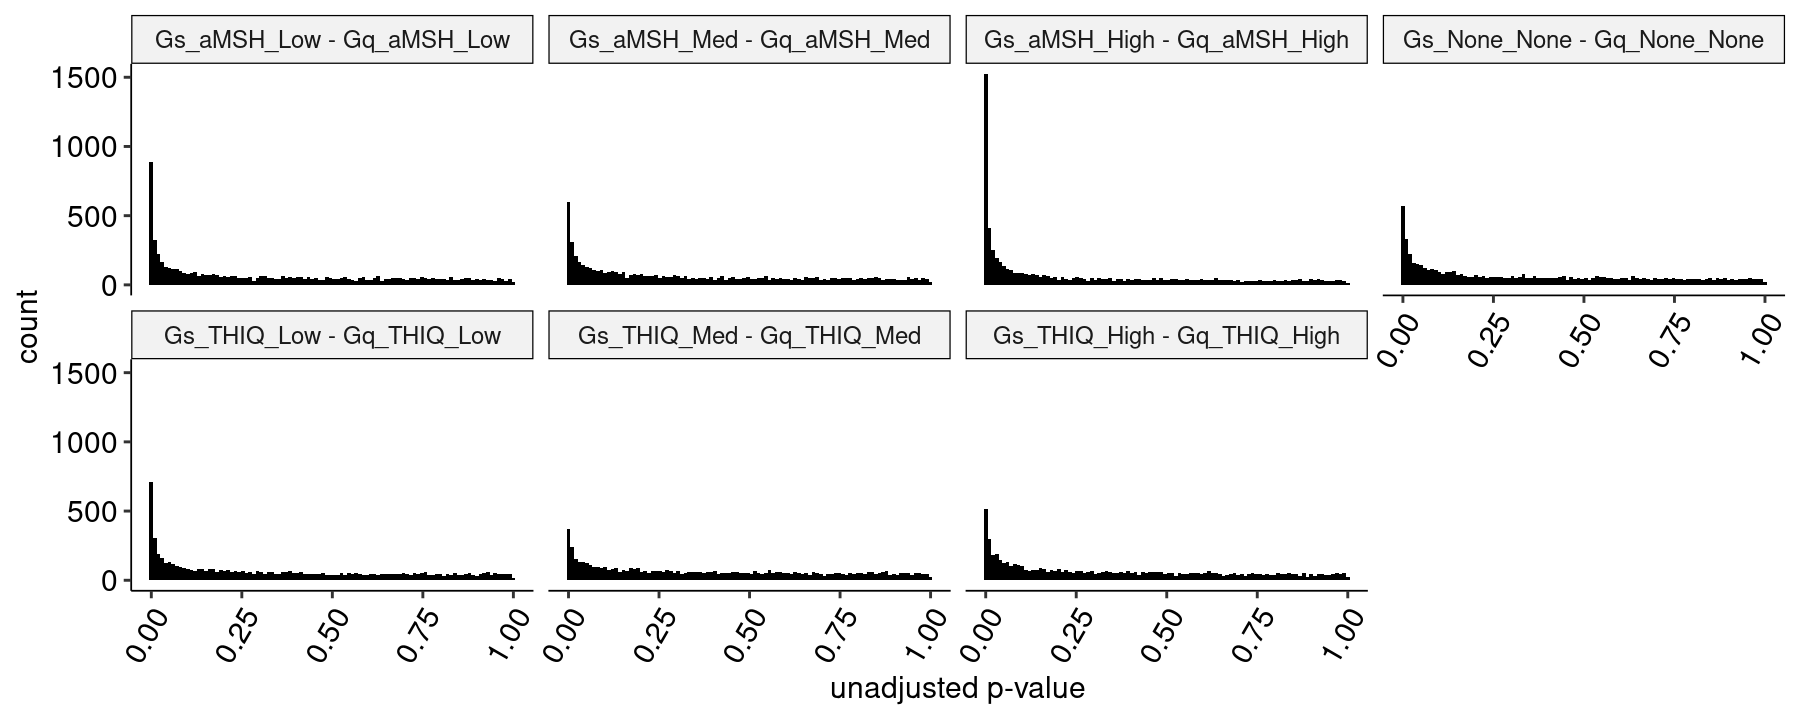

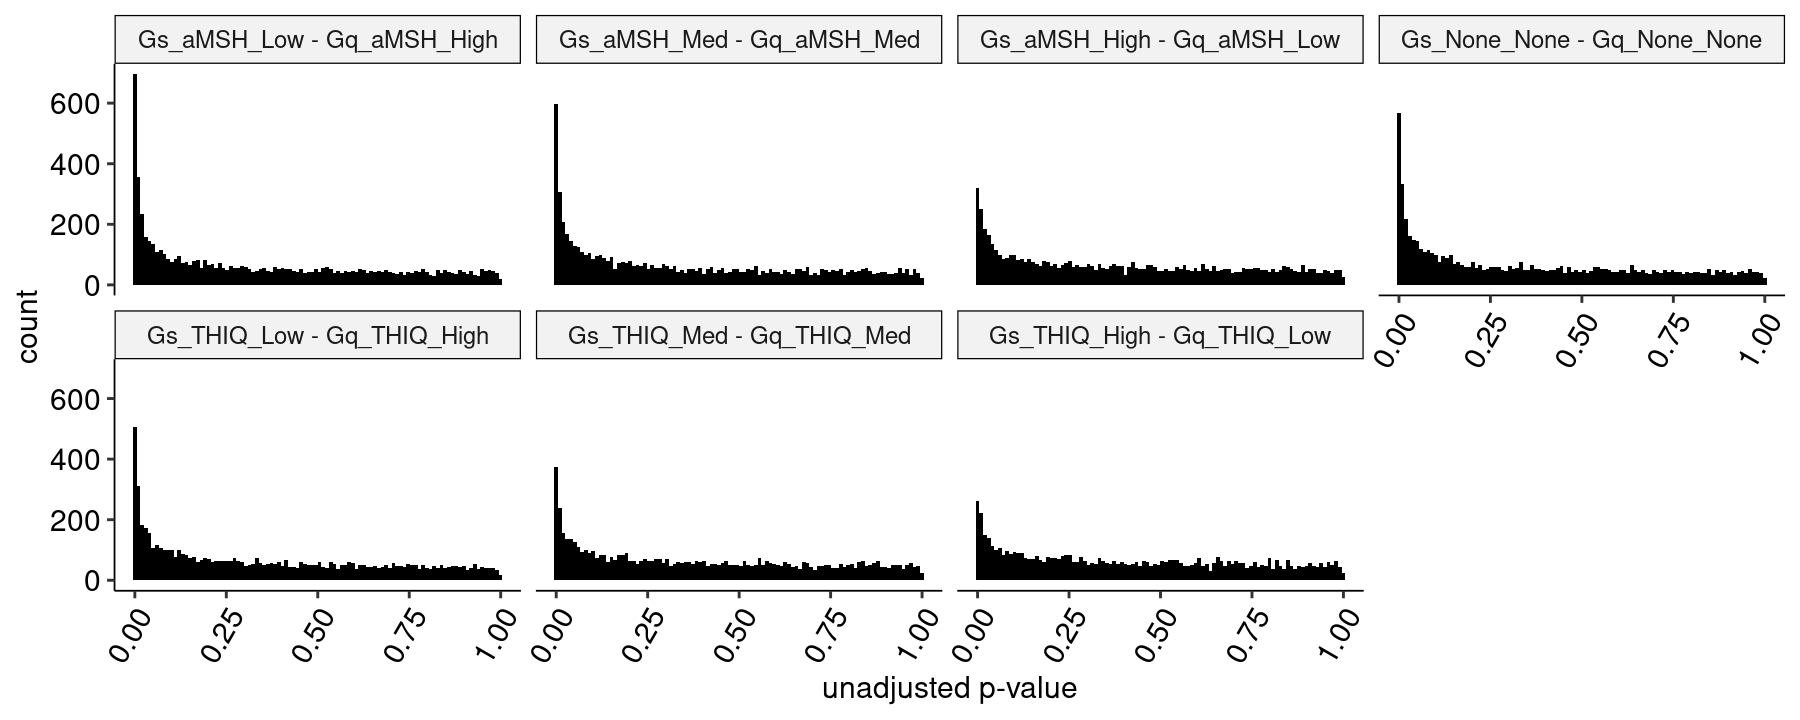

In [9]:
options(repr.plot.width = 15, repr.plot.height = 6)

sumstats_bias %>%
    ggplot() +
        geom_histogram(aes(x = p.value), color = NA, fill = "black", bins = 100) +
        theme_pubr(base_size = 18, x.text.angle = 60) +
        facet_wrap(~condition, nrow = 2) +
        xlab("unadjusted p-value")

sumstats_bias_rev %>%
    ggplot() +
        geom_histogram(aes(x = p.value), color = NA, fill = "black", bins = 100) +
        theme_pubr(base_size = 18, x.text.angle = 60) +
        facet_wrap(~condition, nrow = 2) +
        xlab("unadjusted p-value")

The stop effects are informative, since we expect a stop to be equally damaging to both Gs and Gq. Thus, and differences in the stop profile are presumably due to different degrees of pathway activation by the agonist, not a difference in mutation effects on pathway activation.

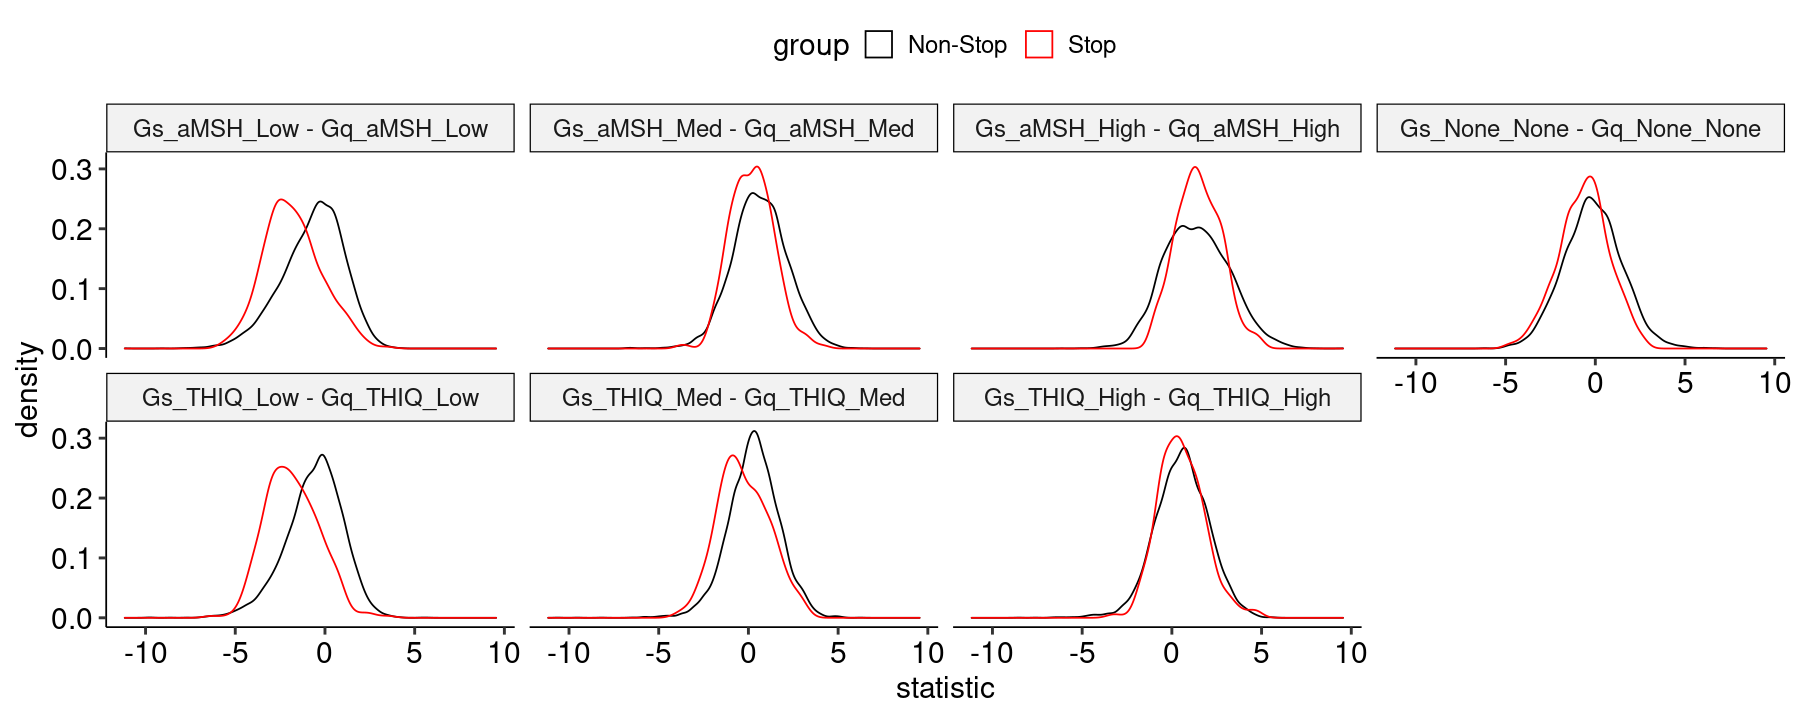

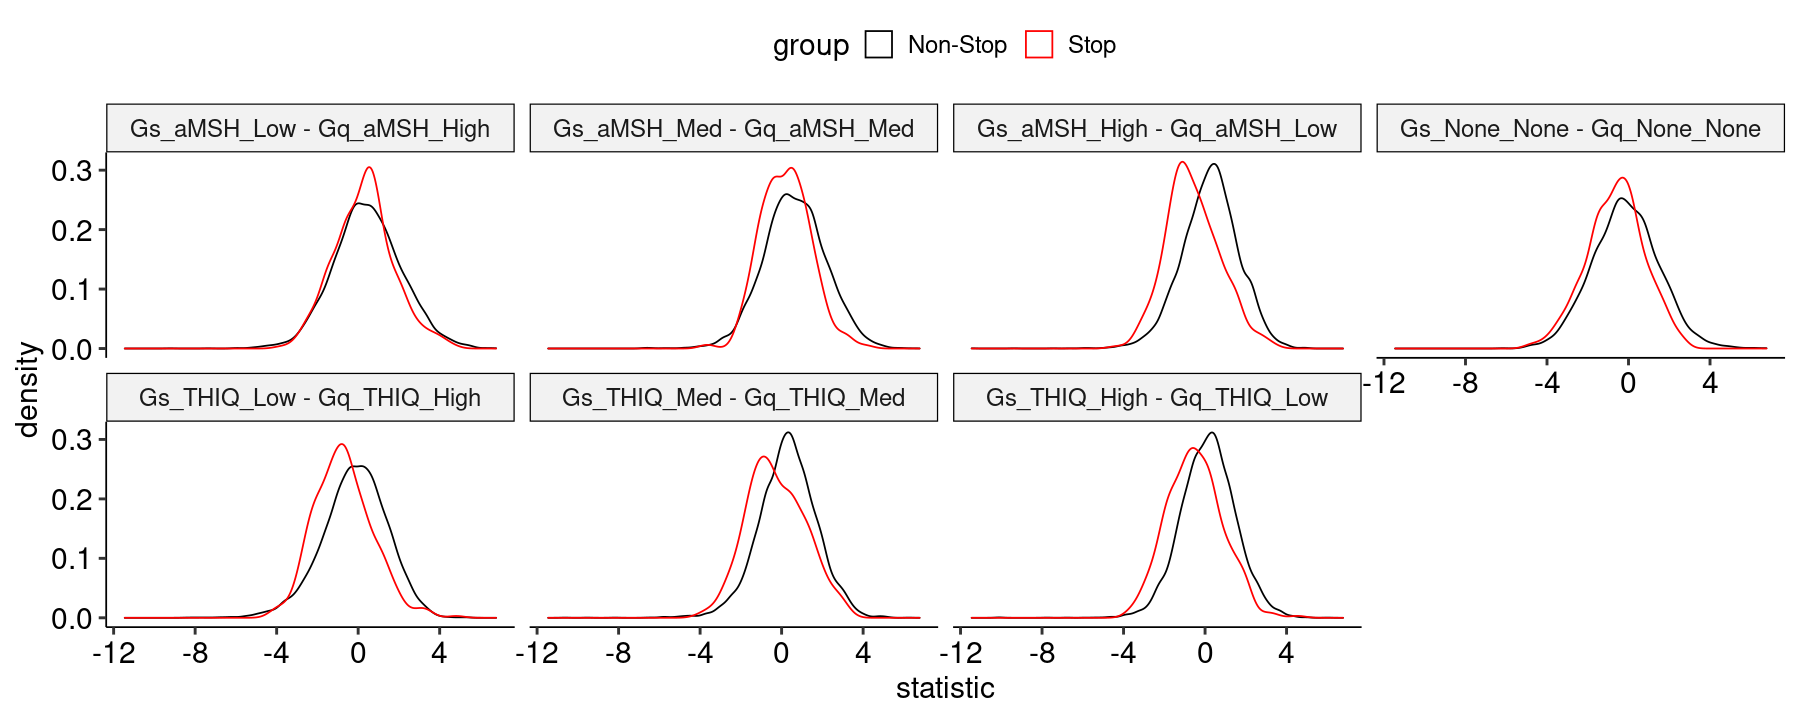

In [10]:
sumstats_bias %>%
    mutate(group = if_else(aa == "*", "Stop", "Non-Stop")) %>%
    ggplot() +
        geom_density(aes(x = statistic, color = group)) + 
        theme_pubr(base_size = 18) +
        facet_wrap(~condition, nrow = 2) +
        scale_color_manual(values = c("Non-Stop" = "black", "Stop" = "red"))

sumstats_bias_rev %>%
    mutate(group = if_else(aa == "*", "Stop", "Non-Stop")) %>%
    ggplot() +
        geom_density(aes(x = statistic, color = group)) + 
        theme_pubr(base_size = 18) +
        facet_wrap(~condition, nrow = 2) +
        scale_color_manual(values = c("Non-Stop" = "black", "Stop" = "red"))

In each comparison, we can apply a 1% FDR threshold and count the number of significant variants in each direction, noting how many are stops in each case:

In [11]:
sumstats_bias %>%
    filter(p.adj < 0.01) %>%
    count(condition,
          "direction" = if_else(estimate > 0, "Gs", "Gq"),
          "group" = if_else(aa == "*", "Stop", "Non-Stop")) %>%
    pivot_wider(names_from = c(direction, group), values_from = n, values_fill = 0) %>%
    relocate(c("Gs_Non-Stop", "Gq_Non-Stop", "Gs_Stop", "Gq_Stop"), .after = condition) %>%
    mutate("total" = `Gs_Non-Stop` + `Gq_Non-Stop` + Gs_Stop + Gq_Stop)

condition,Gs_Non-Stop,Gq_Non-Stop,Gs_Stop,Gq_Stop,total
<fct>,<int>,<int>,<int>,<int>,<int>
Gs_aMSH_Low - Gq_aMSH_Low,11,430,0,46,487
Gs_aMSH_Med - Gq_aMSH_Med,199,39,2,2,242
Gs_aMSH_High - Gq_aMSH_High,830,23,18,0,871
Gs_None_None - Gq_None_None,102,122,0,9,233
Gs_THIQ_Low - Gq_THIQ_Low,15,309,1,40,365
Gs_THIQ_Med - Gq_THIQ_Med,66,58,0,4,128
Gs_THIQ_High - Gq_THIQ_High,140,63,8,0,211


And then the same for the reversed comparisons (note that the medium comparison changes due to multiple testing correction being applied to a different total set of p-values, even though the raw p-values would be the same). In all conditions, there are fewer significant stops:

In [12]:
sumstats_bias_rev %>%
    filter(p.adj < 0.01) %>%
    count(condition,
          "direction" = if_else(estimate > 0, "Gs", "Gq"),
          "group" = if_else(aa == "*", "Stop", "Non-Stop")) %>%
    pivot_wider(names_from = c(direction, group), values_from = n, values_fill = 0) %>%
    relocate(c("Gs_Non-Stop", "Gq_Non-Stop", "Gs_Stop", "Gq_Stop"), .after = condition)   %>%
    mutate("total" = `Gs_Non-Stop` + `Gq_Non-Stop` + Gs_Stop + Gq_Stop)   

condition,Gs_Non-Stop,Gq_Non-Stop,Gs_Stop,Gq_Stop,total
<fct>,<int>,<int>,<int>,<int>,<int>
Gs_aMSH_Low - Gq_aMSH_High,182,54,6,1,243
Gs_aMSH_Med - Gq_aMSH_Med,135,29,2,1,167
Gs_aMSH_High - Gq_aMSH_Low,31,38,0,2,71
Gs_None_None - Gq_None_None,73,92,0,6,171
Gs_THIQ_Low - Gq_THIQ_High,18,133,1,5,157
Gs_THIQ_Med - Gq_THIQ_Med,37,43,0,1,81
Gs_THIQ_High - Gq_THIQ_Low,29,30,1,0,60


### Heatmaps <a name="part2"></a>

Next, we project these into heatmaps as usual. This Z-statistic is scaled in the range (-15 to +5) generally applied to other heatmaps:

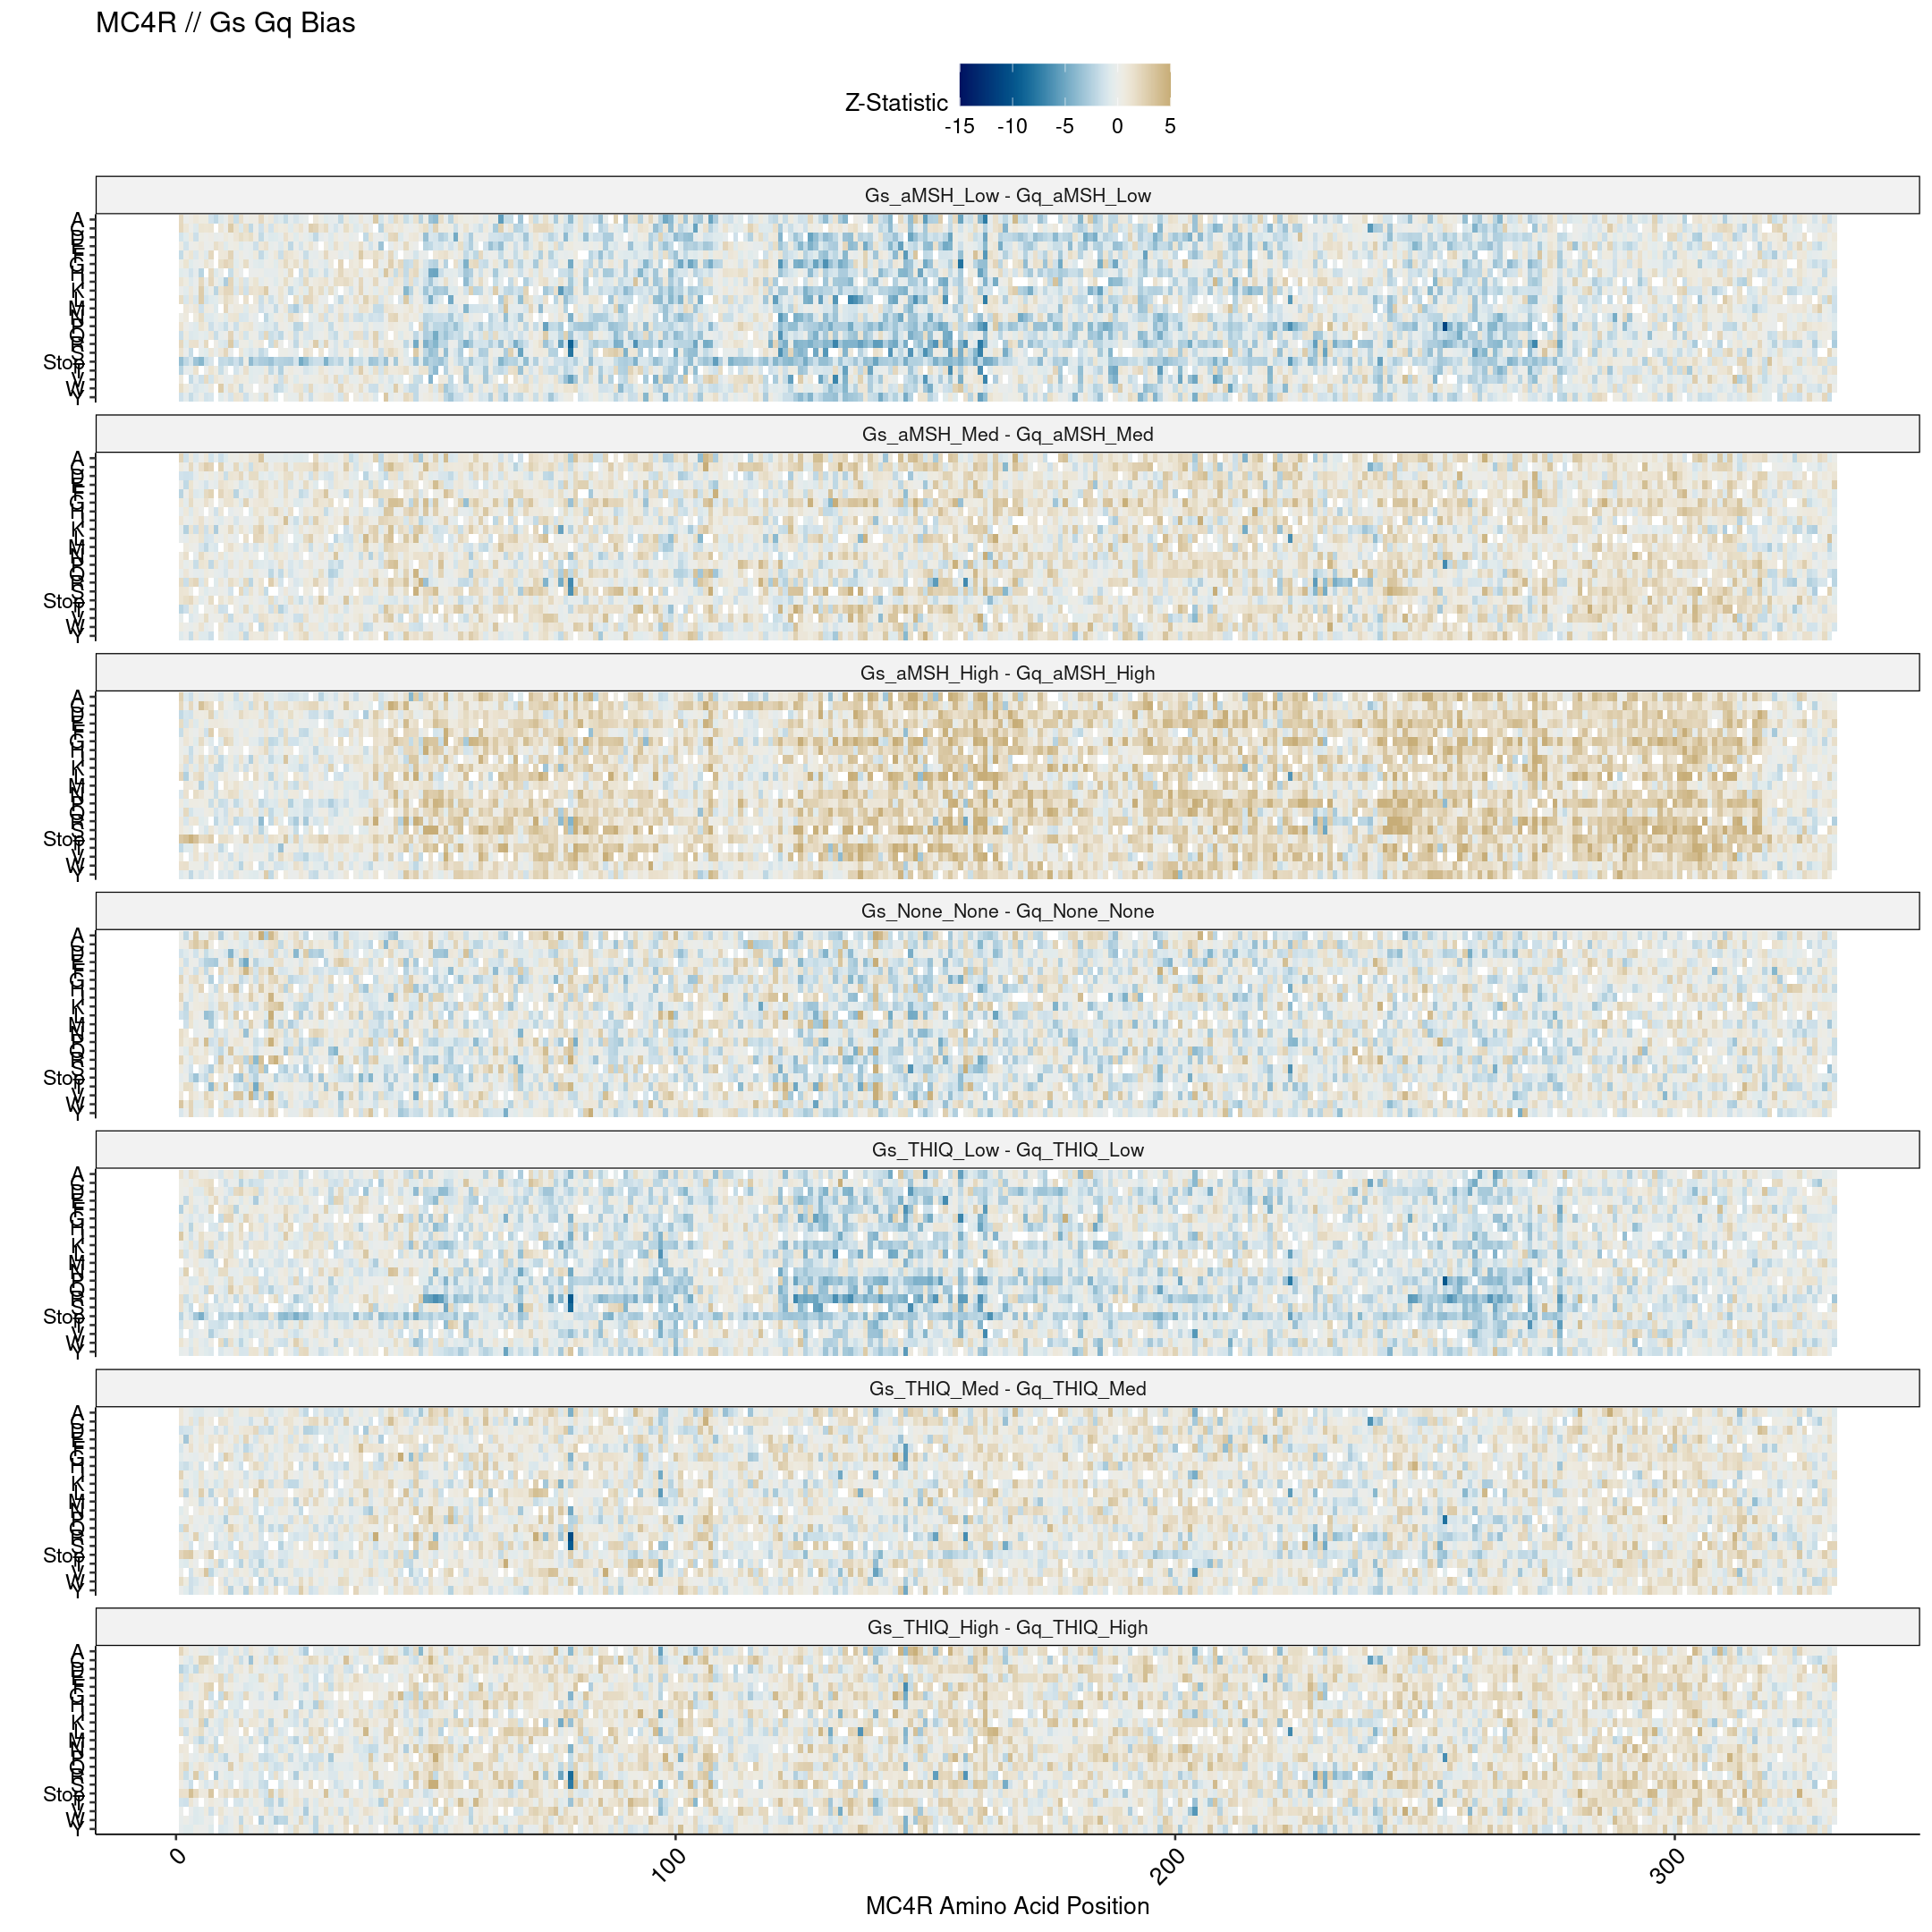

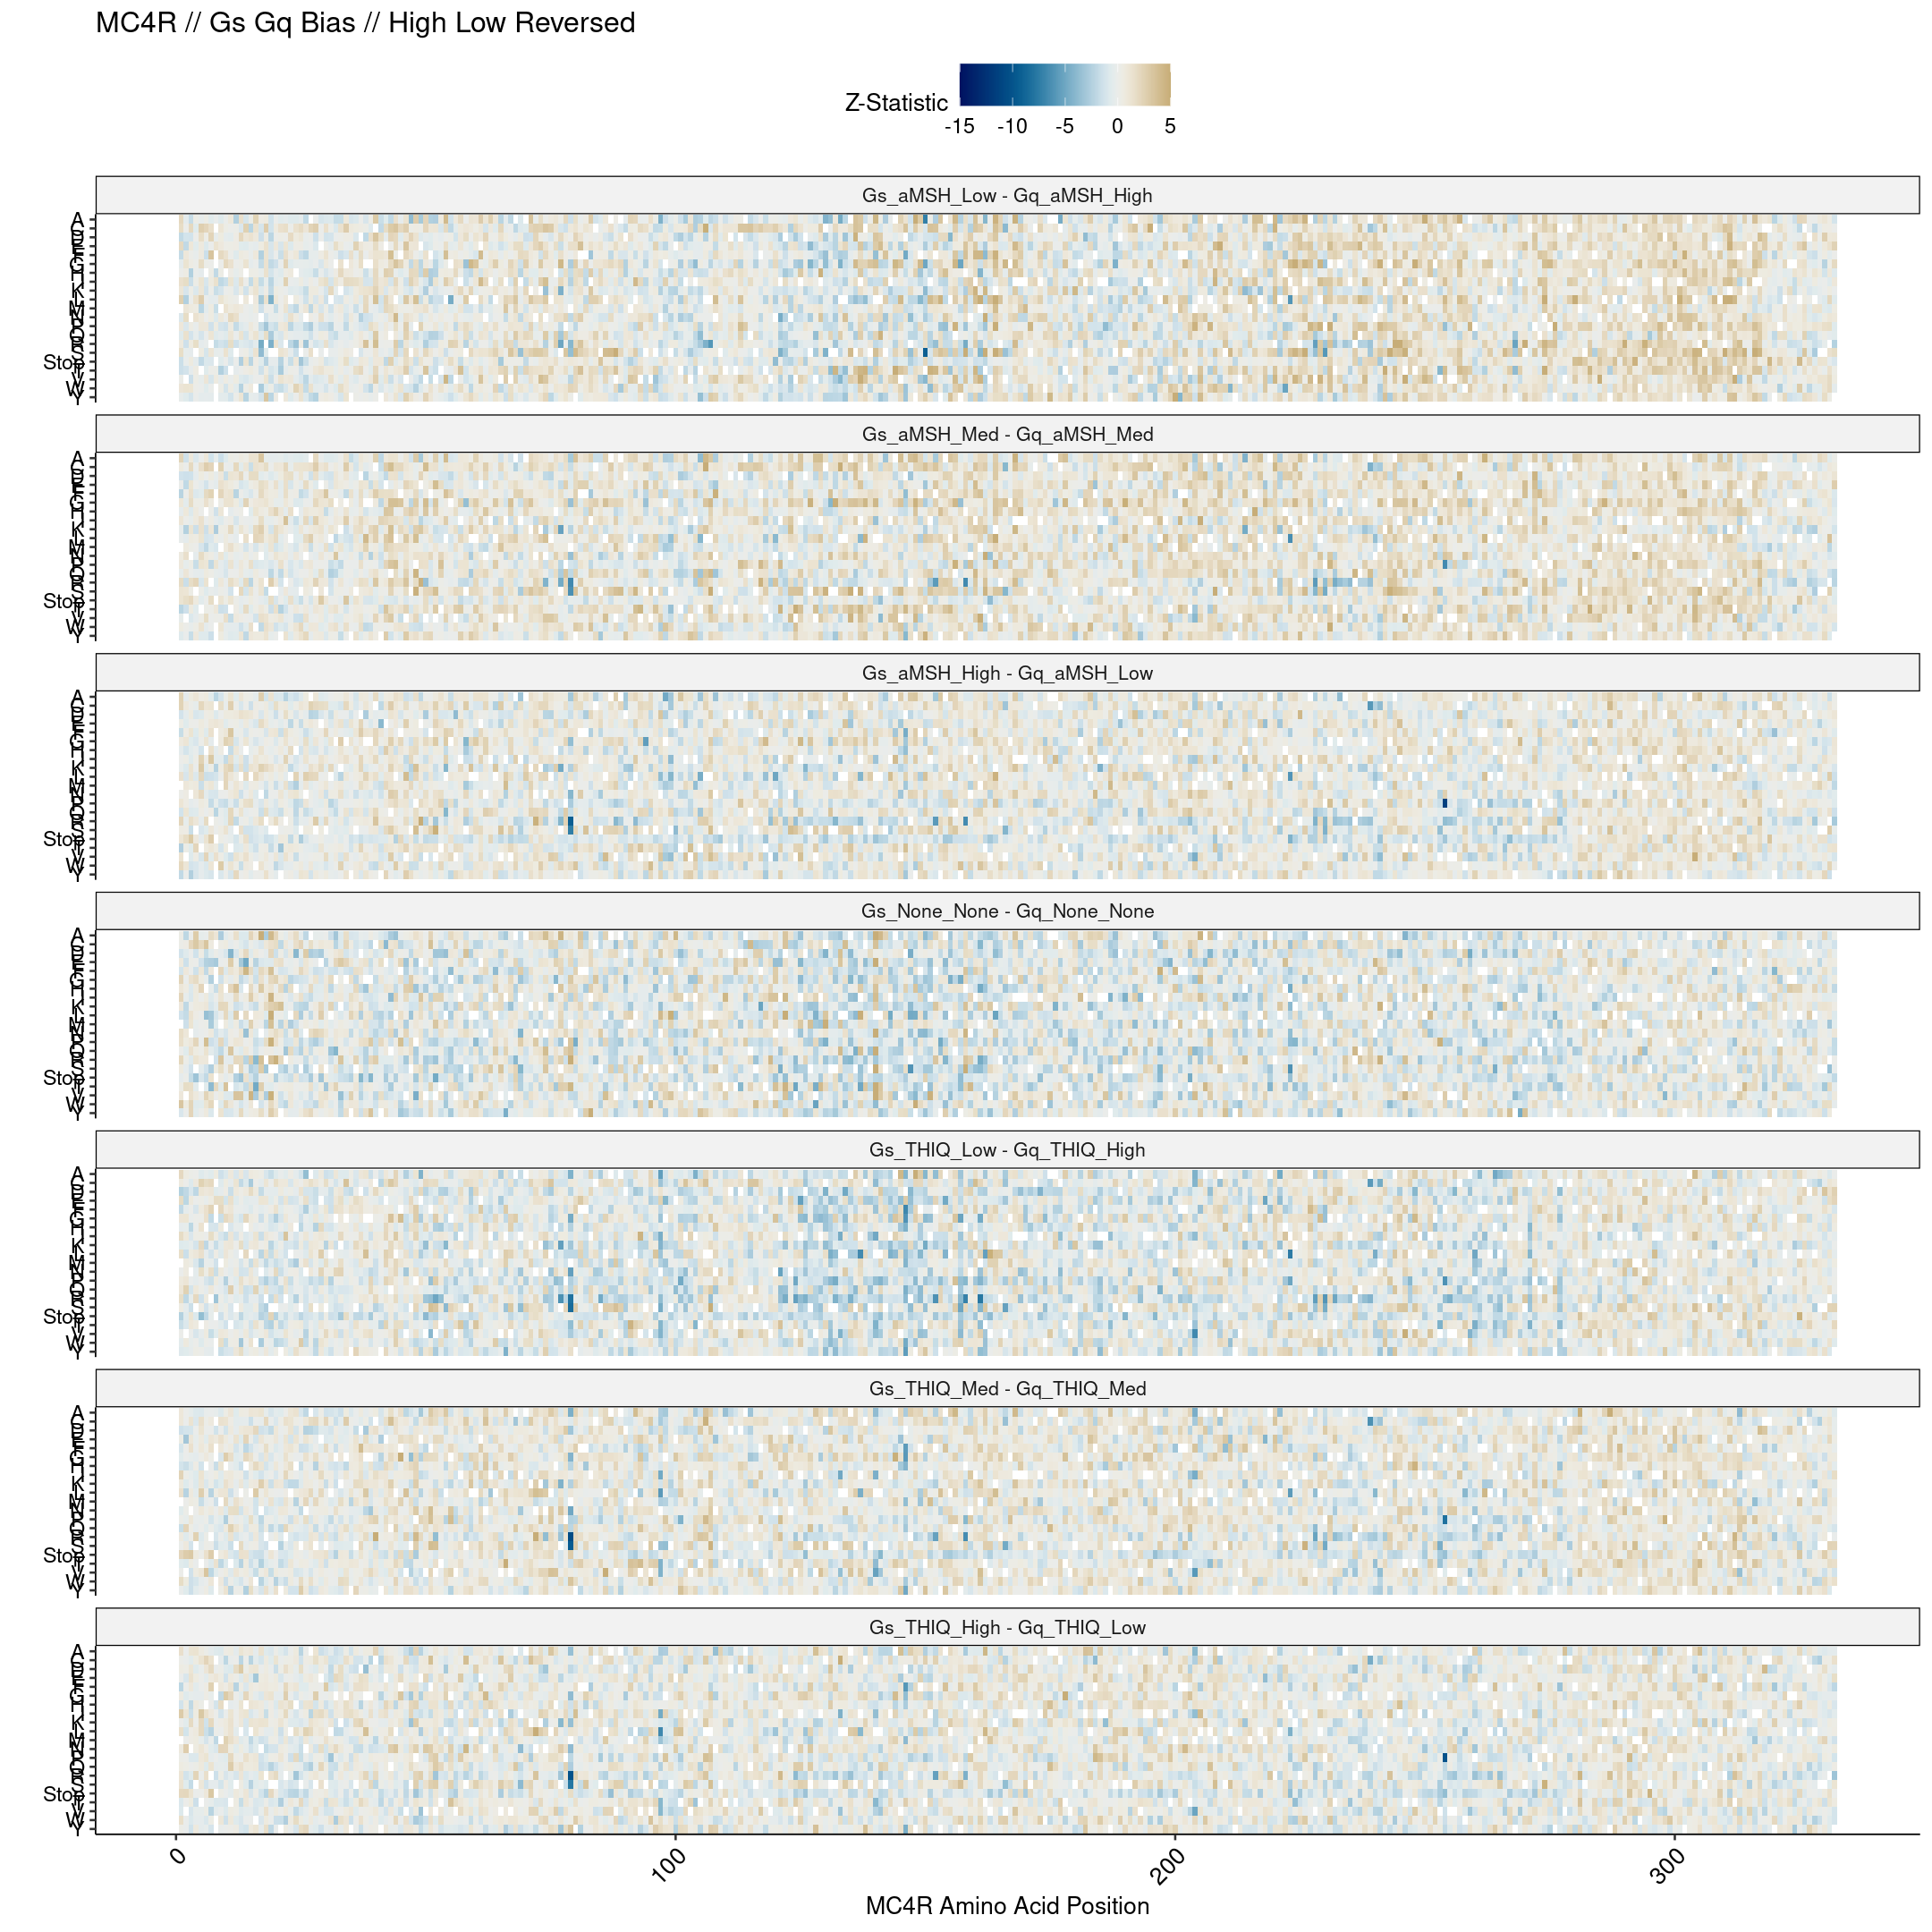

In [13]:
options(repr.plot.width = 18, repr.plot.height = 18)
sumstats_bias %>%
    rename("Z-Statistic" = "statistic") %>%
    mutate(aa = if_else(aa == "*", "Stop", aa)) %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = `Z-Statistic`)) +
            scale_fill_scico_mid(limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("MC4R Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("MC4R // Gs Gq Bias")

sumstats_bias_rev %>%
    rename("Z-Statistic" = "statistic") %>%
    mutate(aa = if_else(aa == "*", "Stop", aa)) %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = `Z-Statistic`)) +
            scale_fill_scico_mid(limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("MC4R Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("MC4R // Gs Gq Bias // High Low Reversed")

When inverted, the Stop bands disappear almost entirely, which is an encouraging sign. We can explore these results in a bit more detail by looking at the top Gs and Gq biased positions across all comparisons, and then examining those positions.

### Biased Positions and Variants <a name="part3"></a>

From the set of significantly biased variants, we can extract the top 15 most significant for each comparison. Since None and Med seem the most well-matched, let's look at those first:

In [14]:
sumstats_bias %>%
    filter(estimate > 0, condition == "Gs_aMSH_Med - Gq_aMSH_Med") %>%
    arrange(p.adj) %>%
    head(n=15) %>%
    select(pos, aa, estimate, std.error, condition, p.adj) %>%
    relocate(condition, .before = pos)

sumstats_bias %>%
    filter(estimate < 0, condition == "Gs_aMSH_Med - Gq_aMSH_Med") %>%
    arrange(p.adj) %>%
    head(n=15) %>%
    select(pos, aa, estimate, std.error, condition, p.adj) %>%
    relocate(condition, .before = pos)

condition,pos,aa,estimate,std.error,p.adj
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Gs_aMSH_Med - Gq_aMSH_Med,107,S,0.9310918,0.1428655,6.156698e-08
Gs_aMSH_Med - Gq_aMSH_Med,164,L,0.7992729,0.1332090,7.207639e-07
Gs_aMSH_Med - Gq_aMSH_Med,106,C,1.4110898,0.2417894,1.677164e-06
Gs_aMSH_Med - Gq_aMSH_Med,133,C,1.8388852,0.3232554,3.244243e-06
Gs_aMSH_Med - Gq_aMSH_Med,231,W,2.6472974,0.4700389,4.217819e-06
Gs_aMSH_Med - Gq_aMSH_Med,161,V,1.1088932,0.2061404,1.365518e-05
Gs_aMSH_Med - Gq_aMSH_Med,216,H,1.7369203,0.3345990,3.015297e-05
Gs_aMSH_Med - Gq_aMSH_Med,162,N,1.1323185,0.2192833,3.416490e-05
Gs_aMSH_Med - Gq_aMSH_Med,208,S,1.3735765,0.2675047,3.823896e-05


condition,pos,aa,estimate,std.error,p.adj
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Gs_aMSH_Med - Gq_aMSH_Med,79,R,-1.2806058,0.1907055,2.181565e-08
Gs_aMSH_Med - Gq_aMSH_Med,158,R,-1.2604460,0.1884001,2.462756e-08
Gs_aMSH_Med - Gq_aMSH_Med,254,P,-1.3015428,0.1952214,2.754899e-08
Gs_aMSH_Med - Gq_aMSH_Med,223,L,-0.8652945,0.1338754,7.907665e-08
Gs_aMSH_Med - Gq_aMSH_Med,79,S,-1.2543983,0.1981559,1.494266e-07
Gs_aMSH_Med - Gq_aMSH_Med,228,R,-0.9505143,0.1652512,2.497869e-06
Gs_aMSH_Med - Gq_aMSH_Med,152,R,-1.0361797,0.1812785,2.914687e-06
Gs_aMSH_Med - Gq_aMSH_Med,77,K,-2.0378593,0.3810963,1.571219e-05
Gs_aMSH_Med - Gq_aMSH_Med,77,R,-0.9997778,0.2062942,1.186649e-04


Immediately, we can see some multi-variant positions, and we can extract and profile the position of the top hit in each direction:

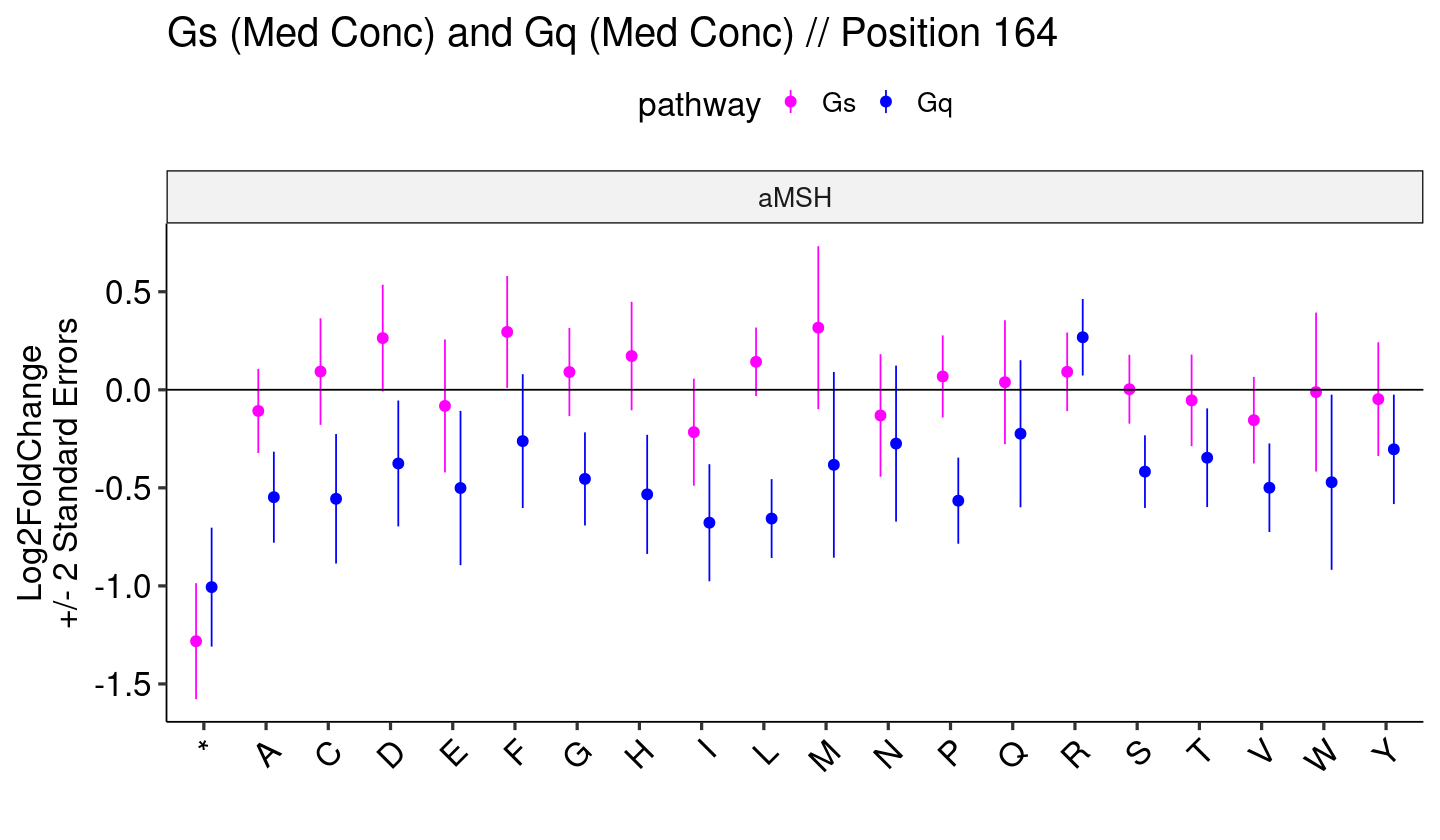

In [15]:
options(repr.plot.width = 12, repr.plot.height = 7)

sumstats %>%
    filter(grepl("Med", condition), pos == 164, drug == "aMSH") %>% 
    mutate(pathway = factor(pathway, levels = c("Gs", "Gq"))) %>%
    ggplot() +
        geom_pointrange(aes(x = aa, y = estimate,
                            ymin = estimate - 2*std.error, ymax = estimate + 2*std.error,
                            color = pathway), position = position_dodge(width = 0.5)) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        ggtitle("Gs (Med Conc) and Gq (Med Conc) // Position 164") +
        xlab("") + ylab("Log2FoldChange\n+/- 2 Standard Errors") +
        geom_hline(yintercept = 0) +
        facet_wrap(~drug) +
        scale_color_manual(values = c("Gs" = "magenta", "Gq" = "blue"))

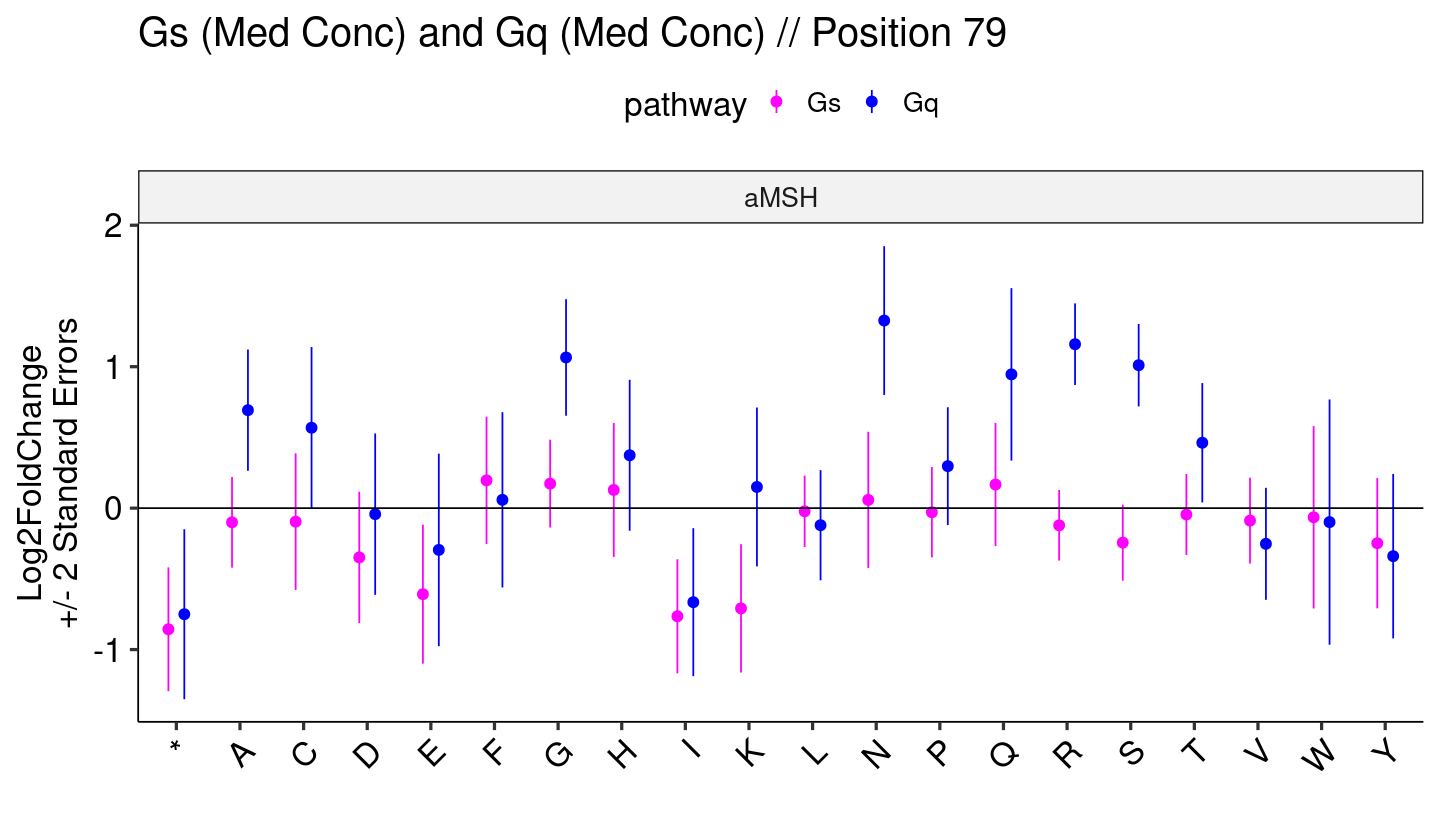

In [16]:
options(repr.plot.width = 12, repr.plot.height = 7)

sumstats %>%
    filter(grepl("Med", condition), pos == 79, drug == "aMSH") %>% 
    mutate(pathway = factor(pathway, levels = c("Gs", "Gq"))) %>%
    ggplot() +
        geom_pointrange(aes(x = aa, y = estimate,
                            ymin = estimate - 2*std.error, ymax = estimate + 2*std.error,
                            color = pathway), position = position_dodge(width = 0.5)) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        ggtitle("Gs (Med Conc) and Gq (Med Conc) // Position 79") +
        xlab("") + ylab("Log2FoldChange\n+/- 2 Standard Errors") +
        geom_hline(yintercept = 0) +
        facet_wrap(~drug) +
        scale_color_manual(values = c("Gs" = "magenta", "Gq" = "blue"))

In [17]:
sumstats_bias %>% write_tsv("../sumstats/MC4R/MC4R-Bias.tsv")

The None condition is of particular interest, since it is the only condition where the concentration matching is absolutely precise. We can extract the top variants in both directions there as well:

In [19]:
sumstats_bias %>%
    filter(condition == "Gs_None_None - Gq_None_None") %>%
    arrange(p.adj) %>%
    head(n=15) %>%
    select(pos, aa, estimate, std.error, condition, p.adj)

pos,aa,estimate,std.error,condition,p.adj
<dbl>,<chr>,<dbl>,<dbl>,<fct>,<dbl>
140,V,1.6394493,0.2421233,Gs_None_None - Gq_None_None,1.630696e-08
140,N,2.4913374,0.3733423,Gs_None_None - Gq_None_None,2.705063e-08
223,S,-0.9563646,0.1530305,Gs_None_None - Gq_None_None,2.249252e-07
140,Q,2.0197471,0.3258109,Gs_None_None - Gq_None_None,2.865228e-07
122,L,1.3225628,0.2155991,Gs_None_None - Gq_None_None,3.854305e-07
158,S,1.2656483,0.2068701,Gs_None_None - Gq_None_None,4.109727e-07
147,S,-1.2810549,0.2107587,Gs_None_None - Gq_None_None,4.947043e-07
140,A,1.4511983,0.2434871,Gs_None_None - Gq_None_None,8.736728e-07
140,T,1.4453240,0.2508869,Gs_None_None - Gq_None_None,2.398563e-06


That is a lot of position 140:

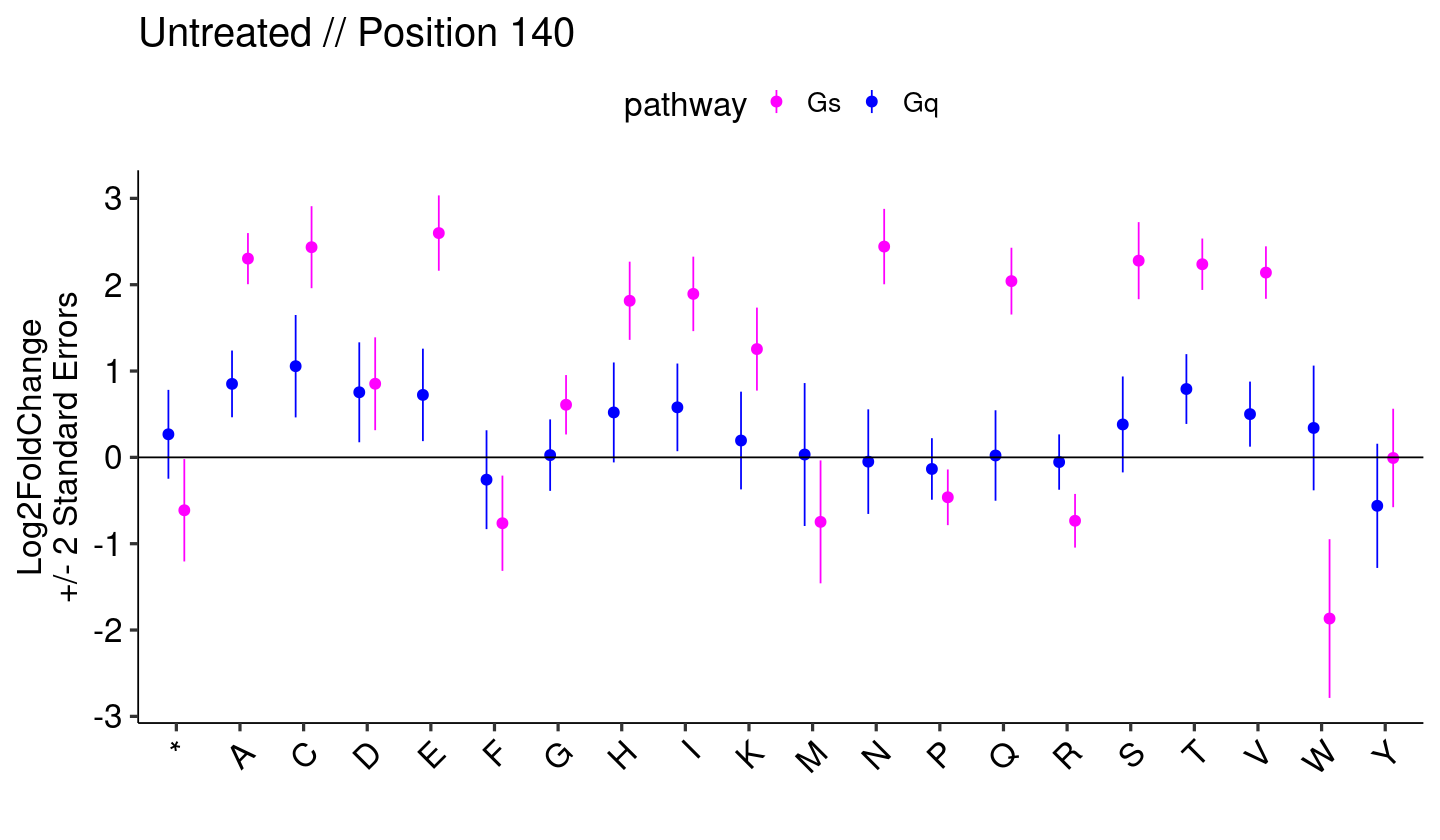

In [20]:
sumstats %>%
    filter(pos == 140, grepl("None", condition)) %>%
    ggplot() +
        geom_pointrange(aes(x = aa, y = estimate,
                            color = pathway,
                            ymin = estimate - 2*std.error,
                            ymax = estimate + 2*std.error),
                        position = position_dodge(width = 0.5)) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        ggtitle("Untreated // Position 140") +
        xlab("") + ylab("Log2FoldChange\n+/- 2 Standard Errors") +
        geom_hline(yintercept = 0) +
        scale_color_manual(values = c("Gs" = "magenta", "Gq" = "blue"))

And the most significant Gq-biased in the same comparison is at position 223. The stop effect here notably is positive in Gq, but not significantly so after adjustment (the most significant hit here is 223S):

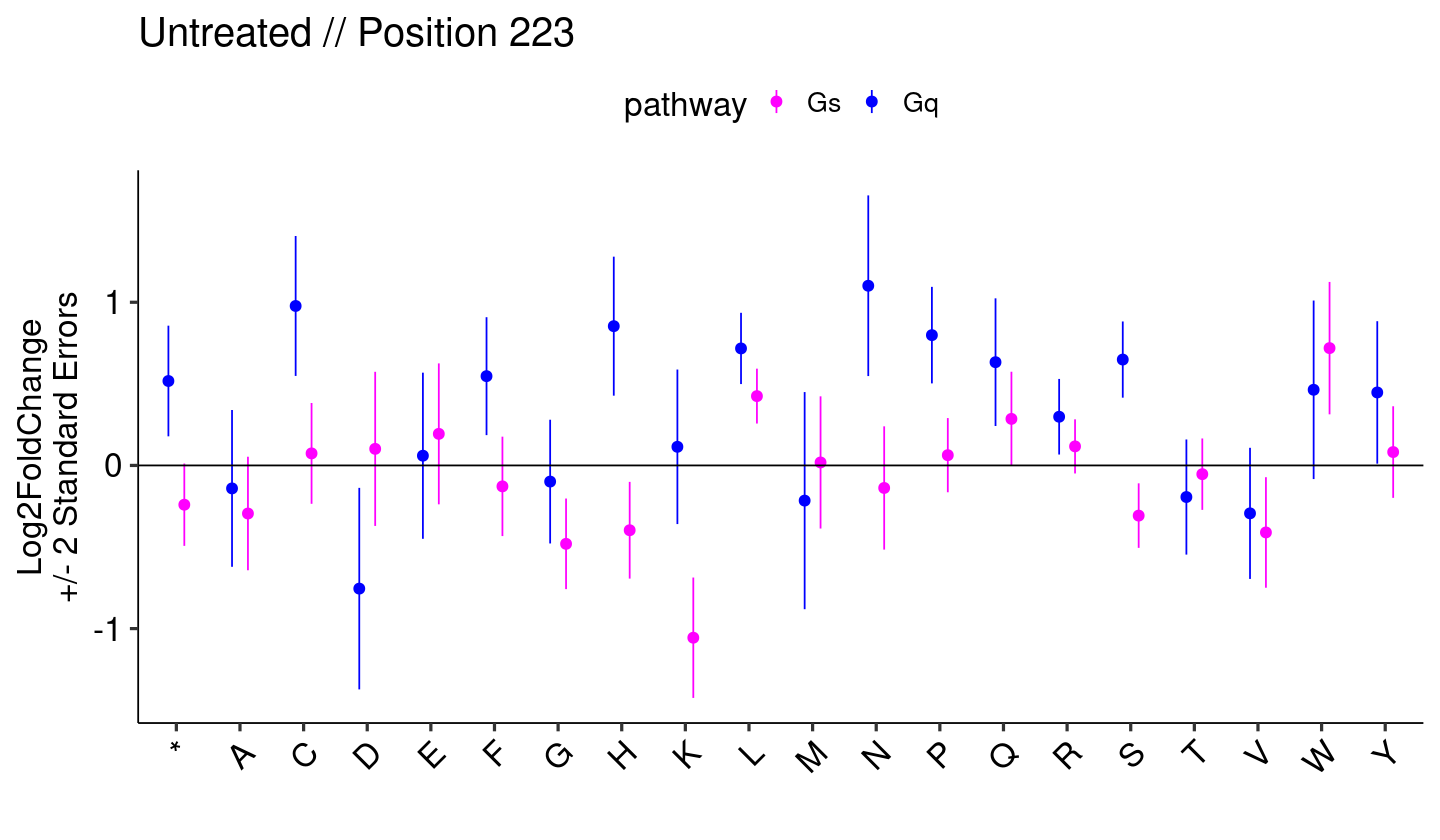

In [21]:
sumstats %>%
    filter(pos == 223, grepl("None", condition)) %>%
    ggplot() +
        geom_pointrange(aes(x = aa, y = estimate,
                            color = pathway,
                            ymin = estimate - 2*std.error,
                            ymax = estimate + 2*std.error),
                        position = position_dodge(width = 0.5)) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        ggtitle("Untreated // Position 223") +
        xlab("") + ylab("Log2FoldChange\n+/- 2 Standard Errors") +
        geom_hline(yintercept = 0) +
        scale_color_manual(values = c("Gs" = "magenta", "Gq" = "blue"))

### Medium Comparisons <a name="part4"></a>

Since the medium concentration pair seems the best calibrated in terms of Stop effects, we can extract just that comparison and plot the Gs/Gq relationship in higher resolution:

In [73]:
sig_bias <- sumstats_bias %>% 
    filter(condition == "Gs_aMSH_Med - Gq_aMSH_Med", p.adj < 0.01) %>%
    mutate(mut_id = paste0(pos, aa)) %>%
    pull(mut_id)

In [173]:
amsh_med_compare <- sumstats %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))  %>%
    filter(condition %in% c("Gs_aMSH_Med", "Gq_aMSH_Med")) %>%
    select(pos, aa, statistic, p.adj, pathway, drug, level) %>%
    pivot_wider(names_from = pathway, values_from = c(statistic, p.adj)) %>%
    mutate("FDR < 0.01" = case_when(p.adj_Gs < 0.01 & p.adj_Gq > 0.01 ~ "Gs",
                           p.adj_Gs > 0.01 & p.adj_Gq < 0.01 ~ "Gq",
                           p.adj_Gs < 0.01 & p.adj_Gq < 0.01 ~ "Both",
                           TRUE ~ "Neither"),
           "Bias" = if_else(paste0(pos, aa) %in% sig_bias, "Biased", "Unbiased"),
           "Stop Group" = if_else(aa == "*", "Stop", "Non-Stop")) 

In [186]:
med_scatter_categ <- ggplot(amsh_med_compare %>% filter(statistic_Gs > -11, statistic_Gs < 6,
                                                  statistic_Gq > -8, statistic_Gq < 10),
                      aes(x = statistic_Gs, y = statistic_Gq, color = `FDR < 0.01`)) +
    geom_point(size = 3) +
    theme_pubr(base_size = 20) +
    geom_abline(slope = 1, intercept = 0) +
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0) +
    theme(legend.pos = "left") +
    xlab("Z-Statistic, Gs (Medium Concentration)") +
    ylab("Z-Statistic, Gq (Medium Concentration)")

med_scatter_categ <- med_scatter_categ +
    geom_xsidedensity(aes(y = stat(density),
                          fill = `Stop Group`), color = NA, alpha = 0.5) +
    geom_ysidedensity(aes(x = stat(density),
                          fill =`Stop Group`), color = NA, alpha = 0.5) +
    theme(ggside.panel.scale.x = 0.25,
          ggside.panel.scale.y = 0.25) +
    scale_fill_manual(values = c("Stop" = "red", "Non-Stop" = "gray")) +
    scale_color_manual(values = c("Both" = "black", "Gs" = "red",
                                  "Gq" = "purple", "Neither" = "gray")) + 
    guides(colour = guide_legend(override.aes = list(size=7)))

In [187]:
med_scatter_bias <- ggplot(amsh_med_compare %>% filter(statistic_Gs > -11, statistic_Gs < 6,
                                                  statistic_Gq > -8, statistic_Gq < 10),
                      aes(x = statistic_Gs, y = statistic_Gq, color = Bias)) +
    geom_point(size = 3) +
    theme_pubr(base_size = 20) +
    geom_abline(slope = 1, intercept = 0) +
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0) +
    theme(legend.pos = "left") +
    xlab("Z-Statistic, Gs (Medium Concentration)") +
    ylab("Z-Statistic, Gq (Medium Concentration)")

med_scatter_bias <- med_scatter_bias +
    geom_xsidedensity(aes(y = stat(density),
                          fill = `Stop Group`), color = NA, alpha = 0.5) +
    geom_ysidedensity(aes(x = stat(density),
                          fill =`Stop Group`), color = NA, alpha = 0.5) +
    theme(ggside.panel.scale.x = 0.25,
          ggside.panel.scale.y = 0.25) +
    scale_fill_manual(values = c("Stop" = "red", "Non-Stop" = "gray")) +
    scale_color_manual(values = c("Biased" = "cyan", "Unbiased" = "gray")) + 
    guides(colour = guide_legend(override.aes = list(size=7)))

In [189]:
ggsave("../dataviz/MC4R/MC4R-Bias-Compare-1.pdf", med_scatter_categ, width = 14, height = 10)
ggsave("../dataviz/MC4R/MC4R-Bias-Compare-2.pdf", med_scatter_bias, width = 14, height = 10)

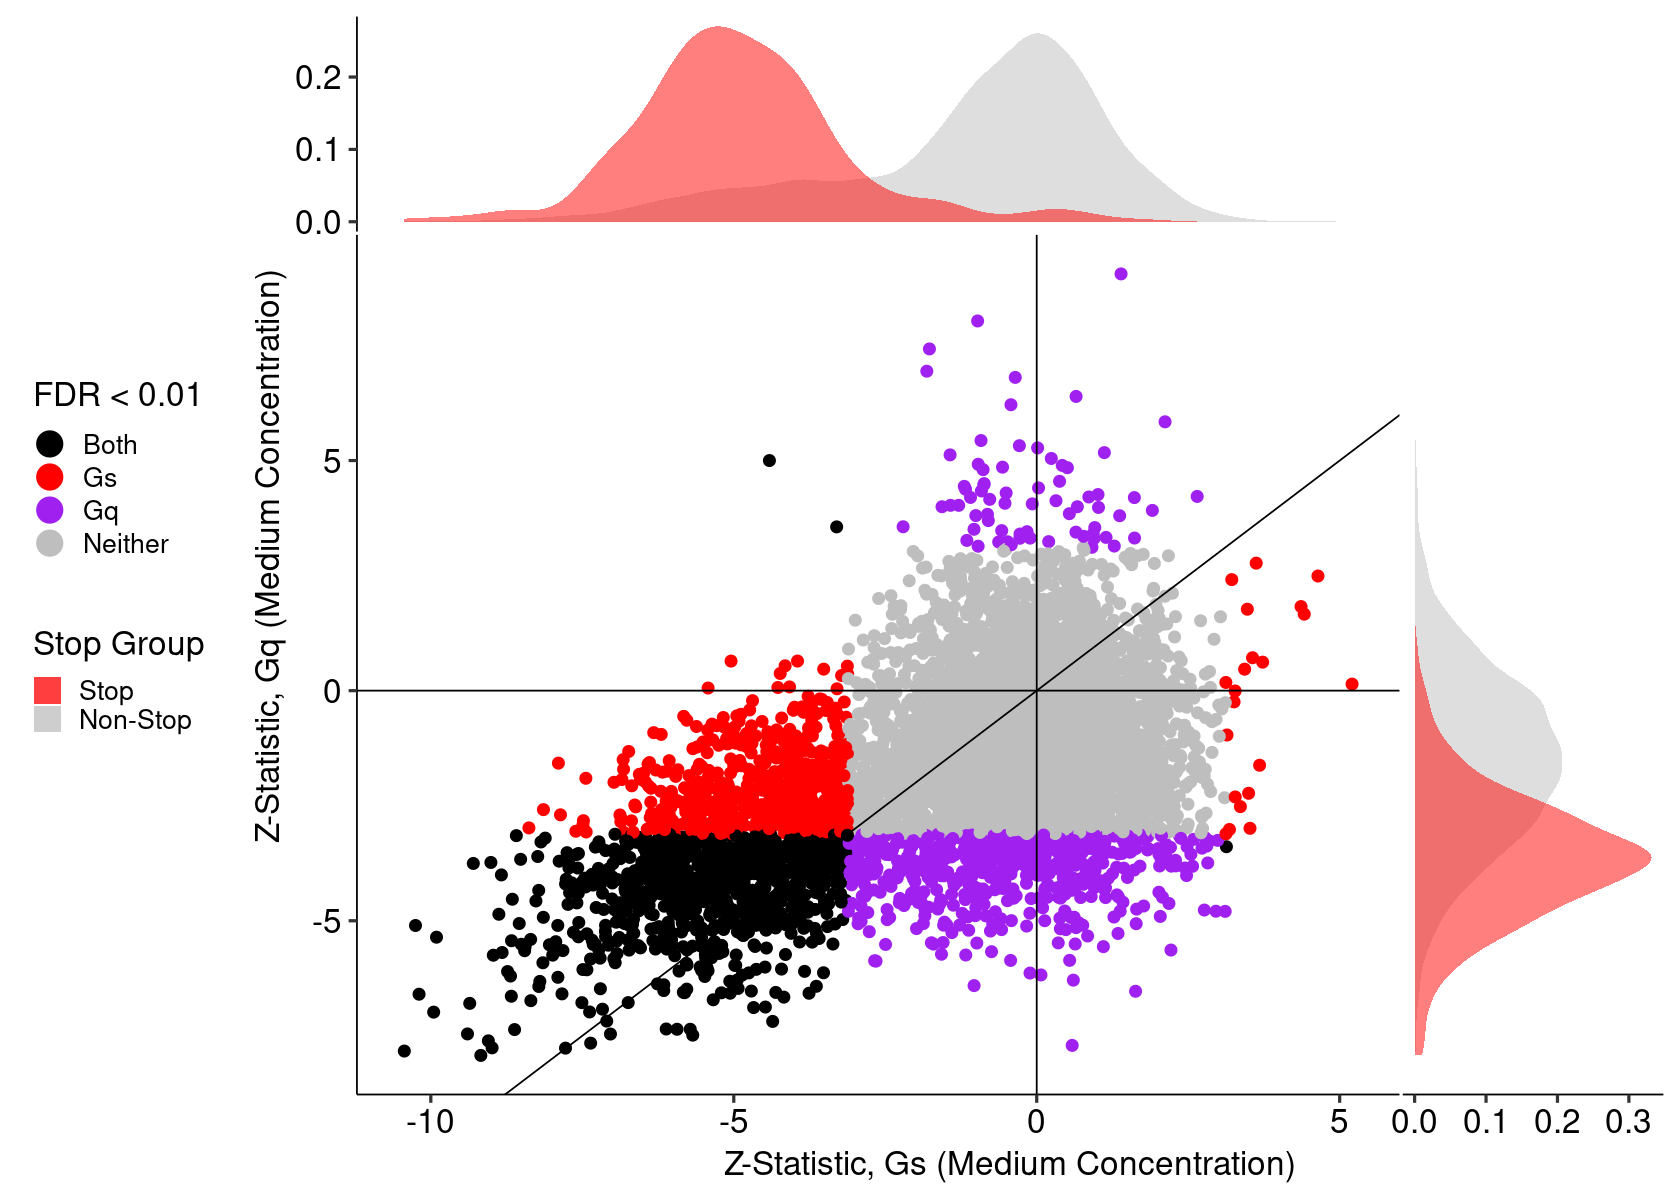

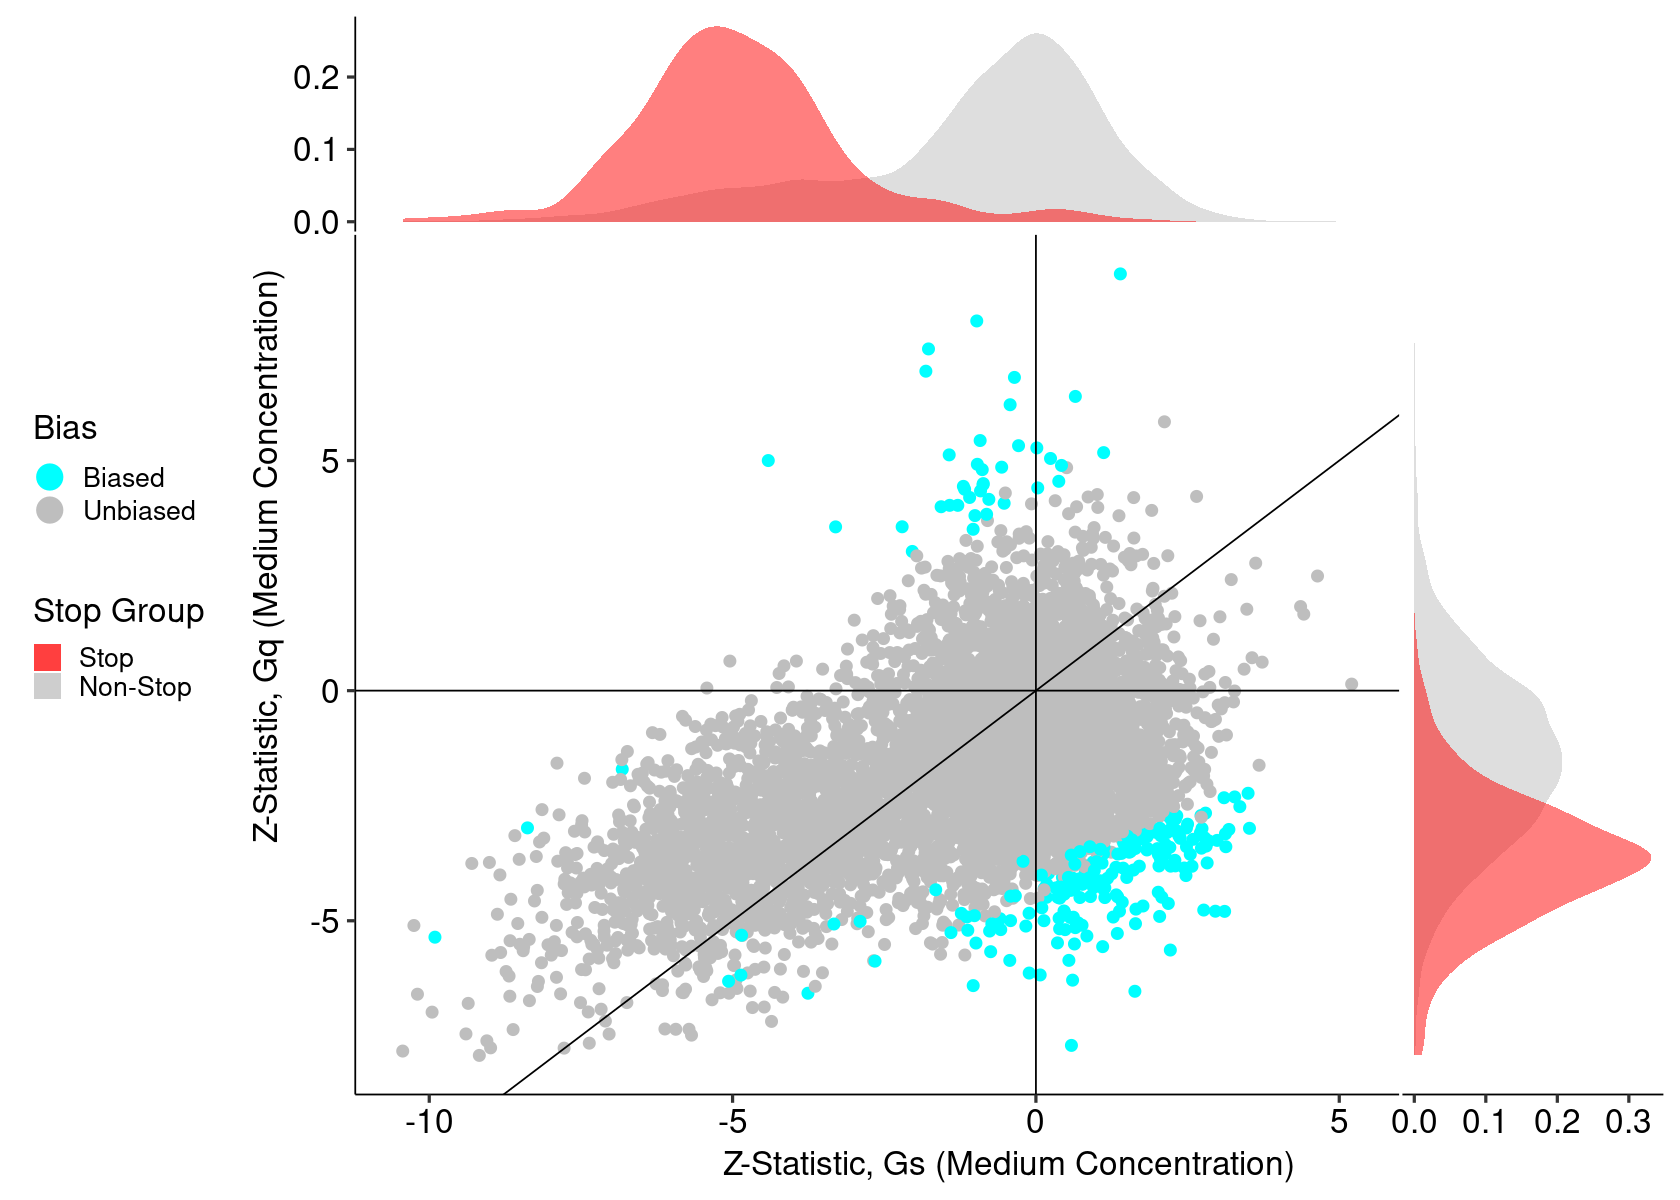

In [188]:
options(repr.plot.width = 14, repr.plot.height = 10)
med_scatter_categ
med_scatter_bias

There are three points that have FDR < 0.01 in both Gs and Gq based on the first plot, but in opposite directions. Those variants are:

In [194]:
amsh_med_compare %>%
    filter(`FDR < 0.01` == "Both", sign(statistic_Gs) != sign(statistic_Gq)) %>%
    select(pos, aa, statistic_Gs, statistic_Gq, Bias)

pos,aa,statistic_Gs,statistic_Gq,Bias
<dbl>,<chr>,<dbl>,<dbl>,<chr>
48,Q,3.130821,-3.391171,Biased
214,K,-3.301927,3.558693,Biased
254,P,-4.411550,5.000009,Biased


We can profile these positions accross both Gs and Gq, and including all variants at those positions for comparison:

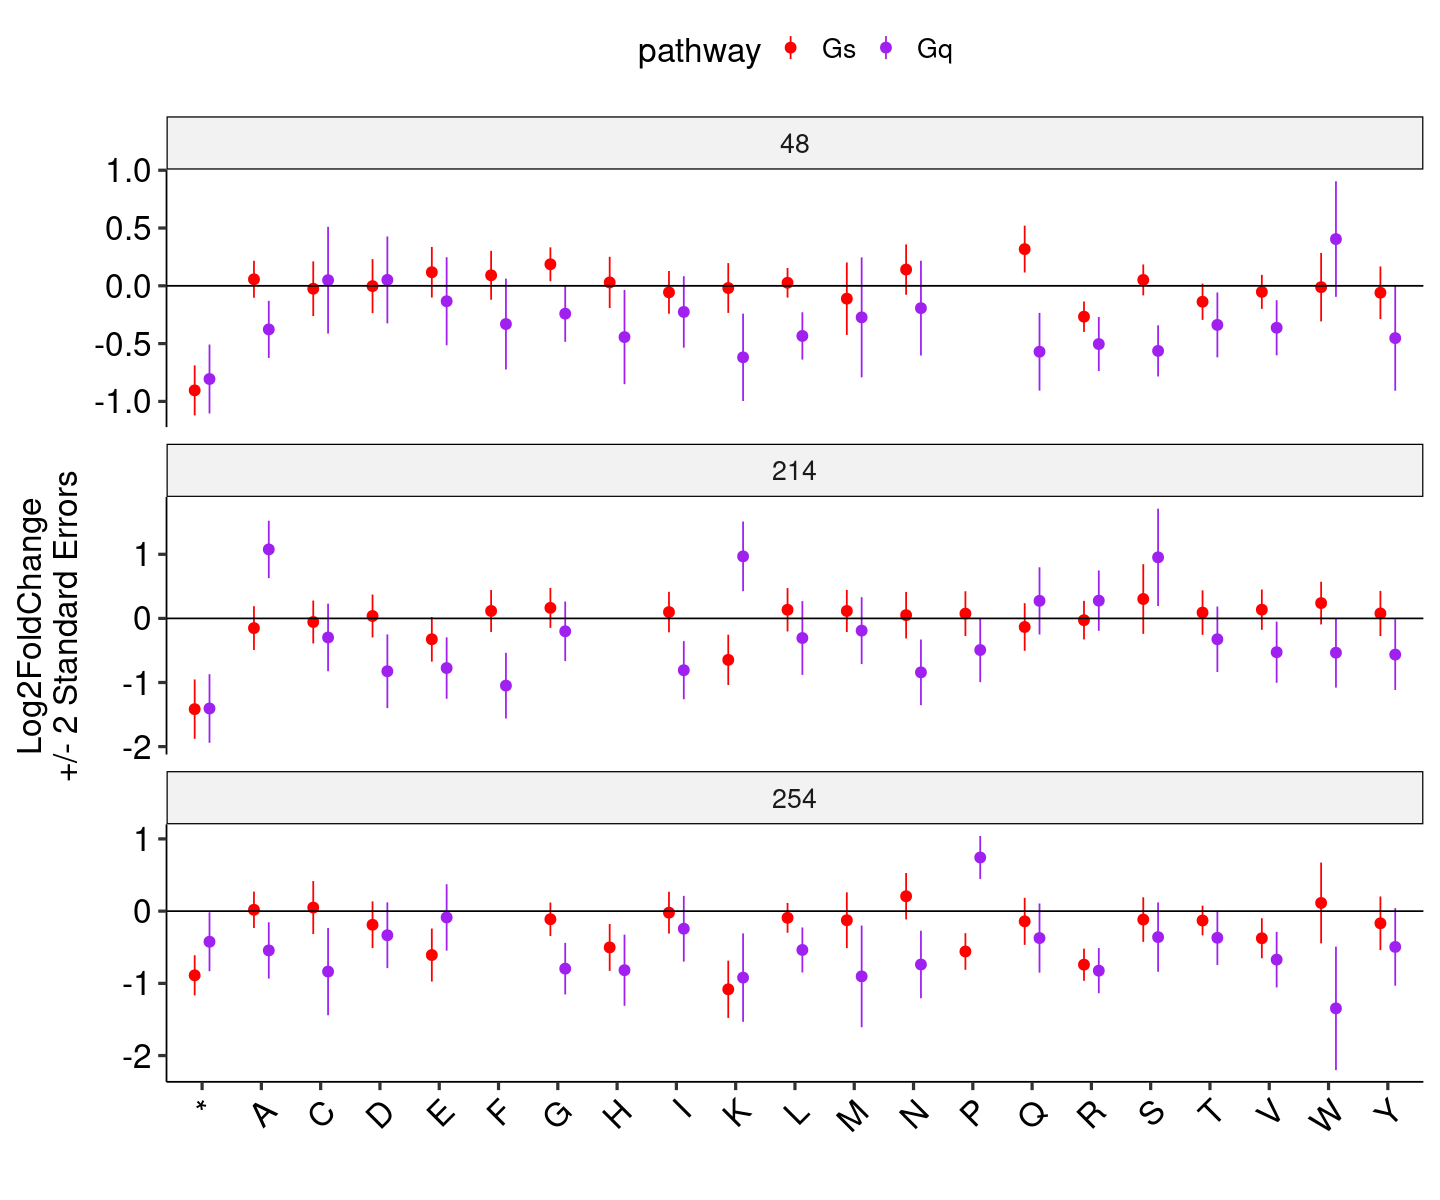

In [202]:
options(repr.plot.width = 12, repr.plot.height = 10)

sumstats %>%
    filter(grepl("Med", condition), pos %in% c(48, 214, 254), drug == "aMSH") %>% 
    mutate(pathway = factor(pathway, levels = c("Gs", "Gq"))) %>%
    ggplot() +
        geom_pointrange(aes(x = aa, y = estimate,
                            ymin = estimate - 2*std.error, ymax = estimate + 2*std.error,
                            color = pathway), position = position_dodge(width = 0.5)) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        xlab("") + ylab("Log2FoldChange\n+/- 2 Standard Errors") +
        geom_hline(yintercept = 0) +
        facet_wrap(~pos, ncol = 1, scales = "free_y") +
        scale_color_manual(values = c("Gs" = "red", "Gq" = "purple"))

Let's extract a more refined variant set with several requirements:

- Negative estimate (LoF) and Significant (FDR < 0.01) in Gq
- Non-Significant (FDR > 0.01) in Gs
- Significant (FDR < 0.01) in Gs - Gq

This returns a list of 166 variants, which we can rank by the `Gs - Gq` FDR (all of these are FDR < 0.01, but we can prioritize the most signifiant biases):

In [284]:
sig_bias <- sumstats_bias %>% 
    filter(condition == "Gs_aMSH_Med - Gq_aMSH_Med", p.adj < 0.01, estimate > 0) %>%
    mutate(mut_id = paste0(pos, aa)) %>%
    select(mut_id, p.adj) %>%
    rename("p.adj_bias" = "p.adj")

sig_sumstats <- sumstats %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"),
           mut_id = paste0(pos, aa)) %>%
    filter(condition %in% c("Gs_aMSH_Med", "Gq_aMSH_Med")) %>% 
    select(mut_id, pos, aa:p.value, pathway:p.adj) %>% 
    pivot_wider(names_from = pathway, values_from = c(estimate:p.value, p.adj)) %>%
    left_join(sig_bias) %>%
    filter(p.adj_Gq < 0.01,
           estimate_Gq < 0,
           p.adj_Gs > 0.01,
           p.adj_bias < 0.01)

Joining, by = "mut_id"


In [354]:
sig_sumstats %>%
    arrange(p.adj_bias) %>%
    select(pos, aa, estimate_Gs, std.error_Gs, estimate_Gq,
           std.error_Gq, p.adj_Gs, p.adj_Gq, p.adj_bias) %>%
    head(15)

sig_sumstats %>%
    arrange(p.adj_bias) %>%
    select(pos, aa, estimate_Gs, std.error_Gs, estimate_Gq,
           std.error_Gq, p.adj_Gs, p.adj_Gq, p.adj_bias) %>%
    write_tsv("../sumstats/MC4R/MC4R-Bias-FilteredSet.tsv")

pos,aa,estimate_Gs,std.error_Gs,estimate_Gq,std.error_Gq,p.adj_Gs,p.adj_Gq,p.adj_bias
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
107,S,0.05019250,0.08574044,-0.8808993,0.1142766,0.75112345,9.453057e-13,6.156698e-08
164,L,0.14259169,0.08740016,-0.6566812,0.1005279,0.25489846,2.197823e-09,7.207639e-07
106,C,0.32213328,0.14538607,-1.0889565,0.1931968,0.09137741,3.418358e-07,1.677164e-06
133,C,0.62766468,0.20178417,-1.2112206,0.2525414,0.01011171,2.022303e-05,3.244243e-06
231,W,0.72622662,0.24552341,-1.9210708,0.4008177,0.01556518,2.049254e-05,4.217819e-06
161,V,0.38688176,0.13985620,-0.7220114,0.1514401,0.02580560,2.293851e-05,1.365518e-05
216,H,0.01295013,0.18460890,-1.7239702,0.2790628,0.97512597,1.779972e-08,3.015297e-05
162,N,0.08642312,0.14297689,-1.0458954,0.1662612,0.74161960,9.285810e-09,3.416490e-05
208,S,0.19906606,0.14834827,-1.1745104,0.2226018,0.37479858,2.109963e-06,3.823896e-05


To verify the patterns we expect, we can extract some of the positions of the most significant variants and plot them as before:

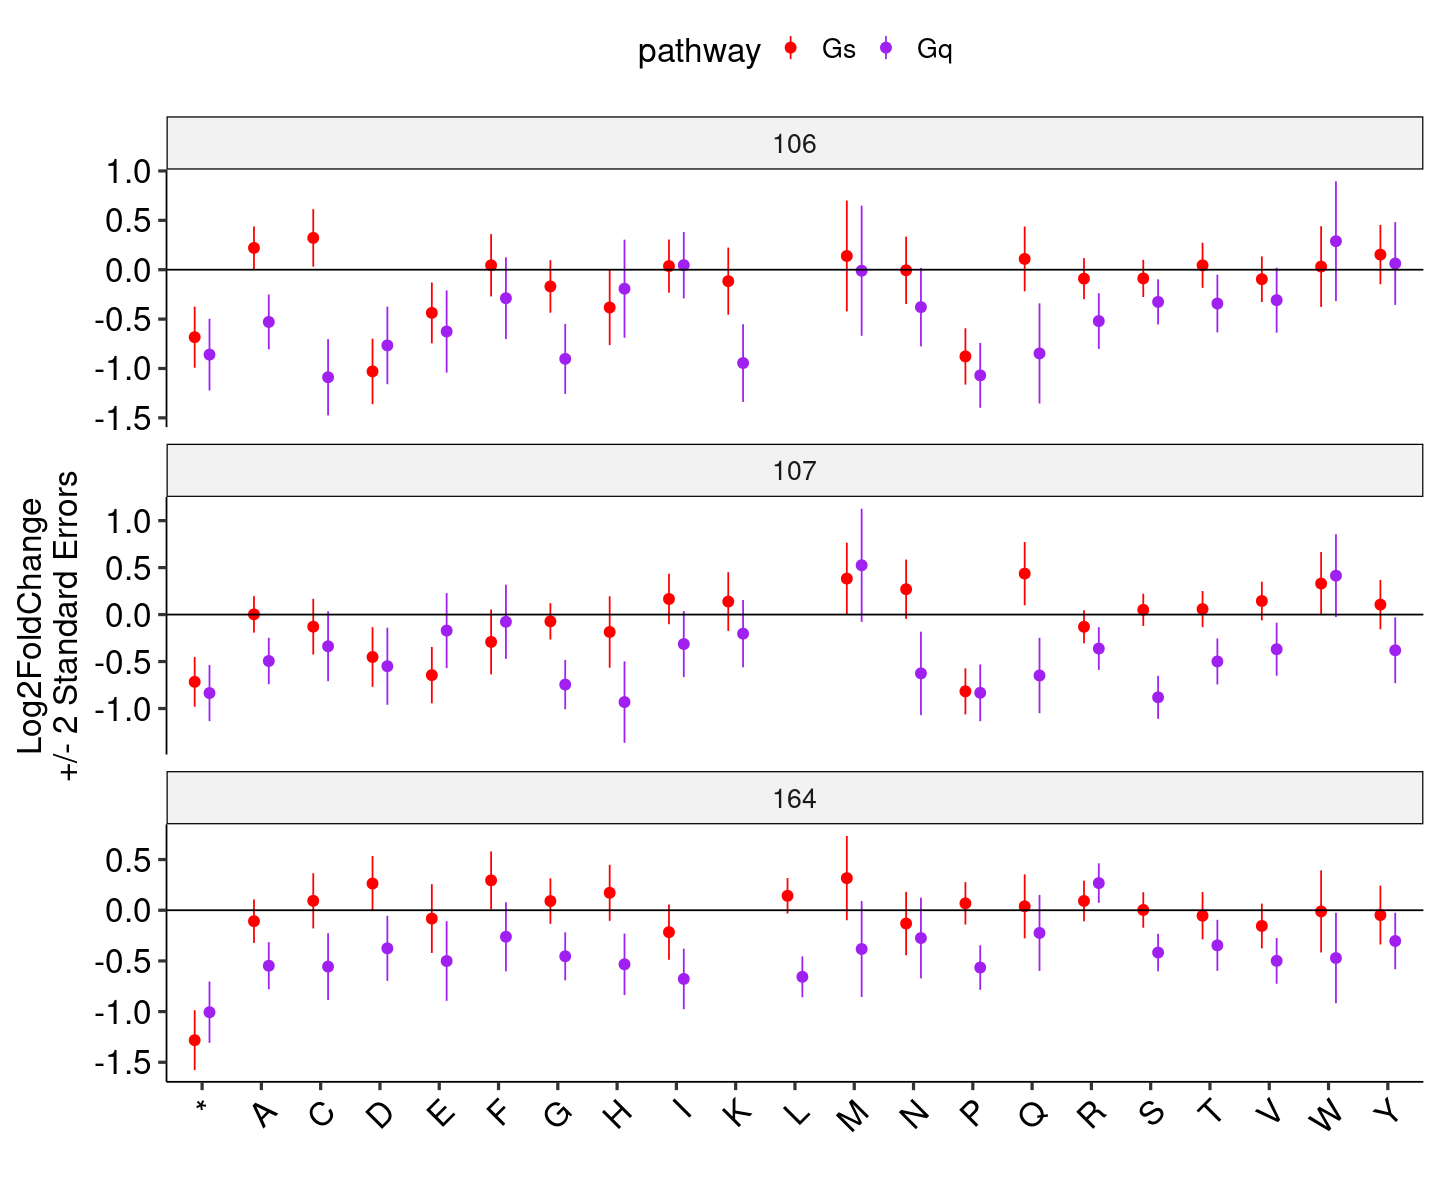

In [286]:
options(repr.plot.width = 12, repr.plot.height = 10)

sumstats %>%
    filter(grepl("Med", condition), pos %in% c(106, 107, 164), drug == "aMSH") %>% 
    mutate(pathway = factor(pathway, levels = c("Gs", "Gq"))) %>%
    ggplot() +
        geom_pointrange(aes(x = aa, y = estimate,
                            ymin = estimate - 2*std.error, ymax = estimate + 2*std.error,
                            color = pathway), position = position_dodge(width = 0.5)) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        xlab("") + ylab("Log2FoldChange\n+/- 2 Standard Errors") +
        geom_hline(yintercept = 0) +
        facet_wrap(~pos, ncol = 1, scales = "free_y") +
        scale_color_manual(values = c("Gs" = "red", "Gq" = "purple"))

These seem to consistently return cases where the stop effects are quite similar, but there are obvious individual variants which damage Gq but not Gs. We can count these by both position and by residue:

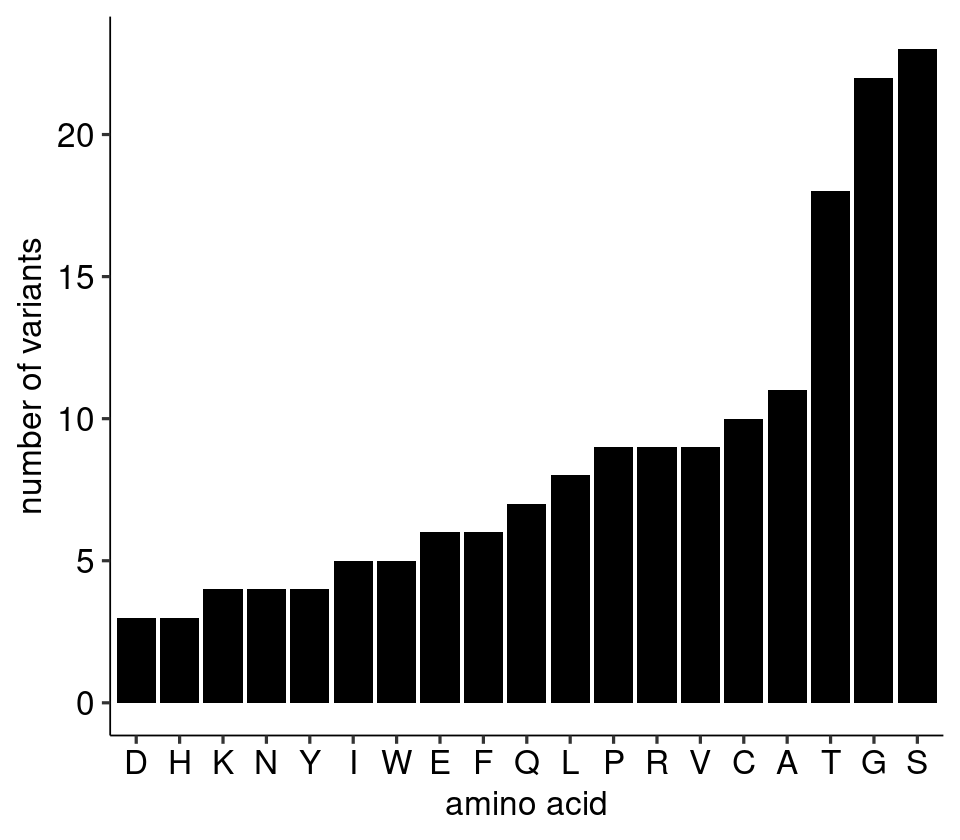

In [288]:
options(repr.plot.width = 8, repr.plot.height = 7)

sig_sumstats %>%
    count(aa) %>%
    ggplot() +
        geom_bar(aes(x = reorder(aa, n), y = n), fill = "black", color = NA, stat = "identity") +
        theme_pubr(base_size = 20) +
        xlab("amino acid") + ylab("number of variants")

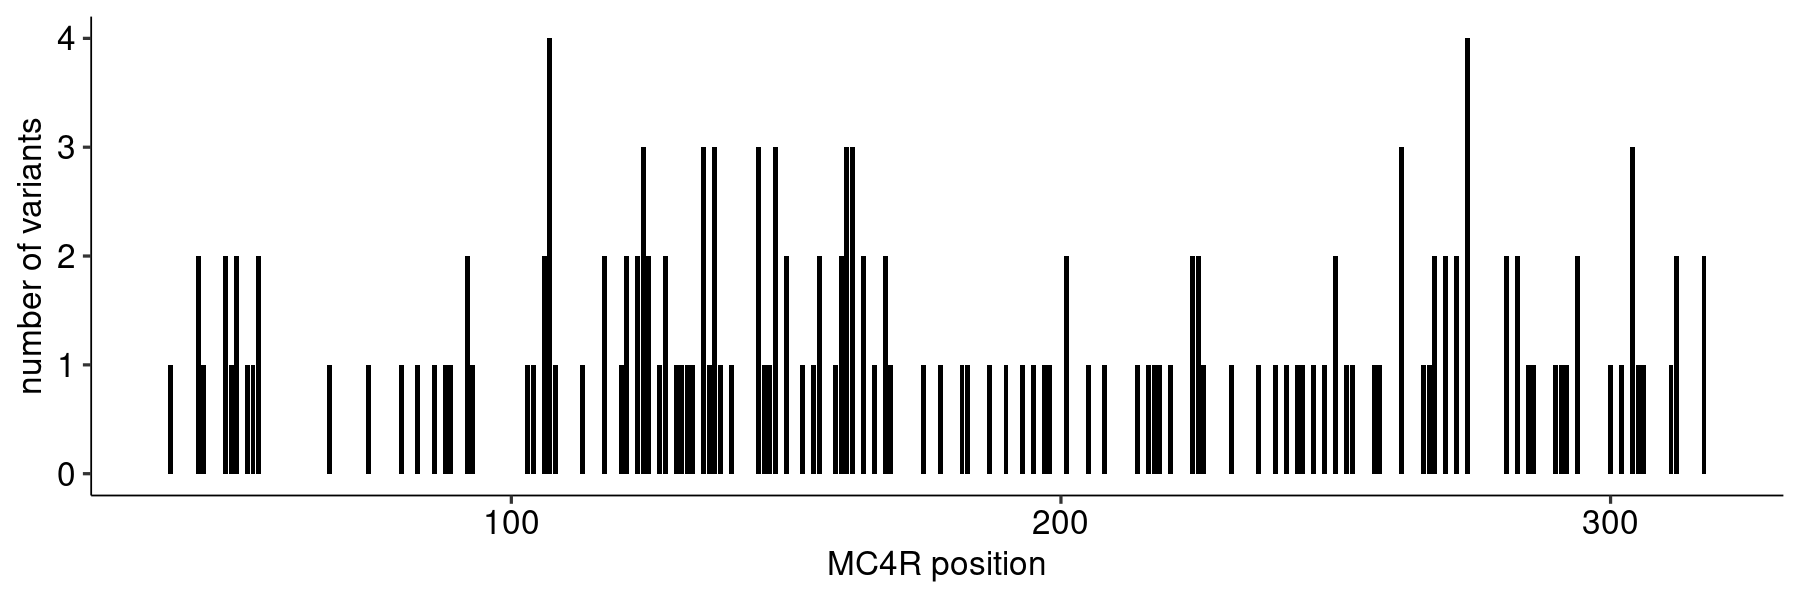

In [289]:
options(repr.plot.width = 15, repr.plot.height = 5)

sig_sumstats %>%
    count(pos) %>%
    ggplot() +
        geom_bar(aes(x = pos, y = n), fill = "black", color = NA, stat = "identity") +
        theme_pubr(base_size = 20) +
        xlab("MC4R position") + ylab("number of variants")

Upon examination, the following positions have 3 or 4 significant variants: 107, 124, 135, 137, 145, 148, 161, 162, 262, 274, 304. We can plot the Gs and Gq summary statistics for those positions in a harmonized format:

In [310]:
sig_pos <- sig_sumstats %>%
    count(pos) %>%
    filter(n >= 3) %>%
    pull(pos)

In [352]:
options(repr.plot.width = 12, repr.plot.height = 35)

tmp_data <- sumstats %>%
    filter(grepl("Med", condition), pos %in% sig_pos, drug == "aMSH") %>% 
    mutate(pathway = factor(pathway, levels = c("Gs", "Gq")),
           bias = if_else(paste0(pos, aa) %in% sig_bias$mut_id, "Biased", "Unbiased"))

plot_example <- function(pos_id, data = tmp_data){
    
    the_plot <- ggplot(data %>% filter(pos == pos_id)) +
        geom_pointrange(aes(x = aa, y = estimate,
                            ymin = estimate - 2*std.error, ymax = estimate + 2*std.error,
                            color = pathway), position = position_dodge(width = 0.5)) +
        theme_pubr(base_size = 20) +
        xlab("") + ylab("") +
        geom_hline(yintercept = 0) +
        facet_grid(rows = vars(pos), cols = vars(bias), space = "free", scales = "free") +
        scale_color_manual(values = c("Gs" = "red", "Gq" = "purple")) +
        theme(legend.pos = "none")
    
    return(the_plot)
}

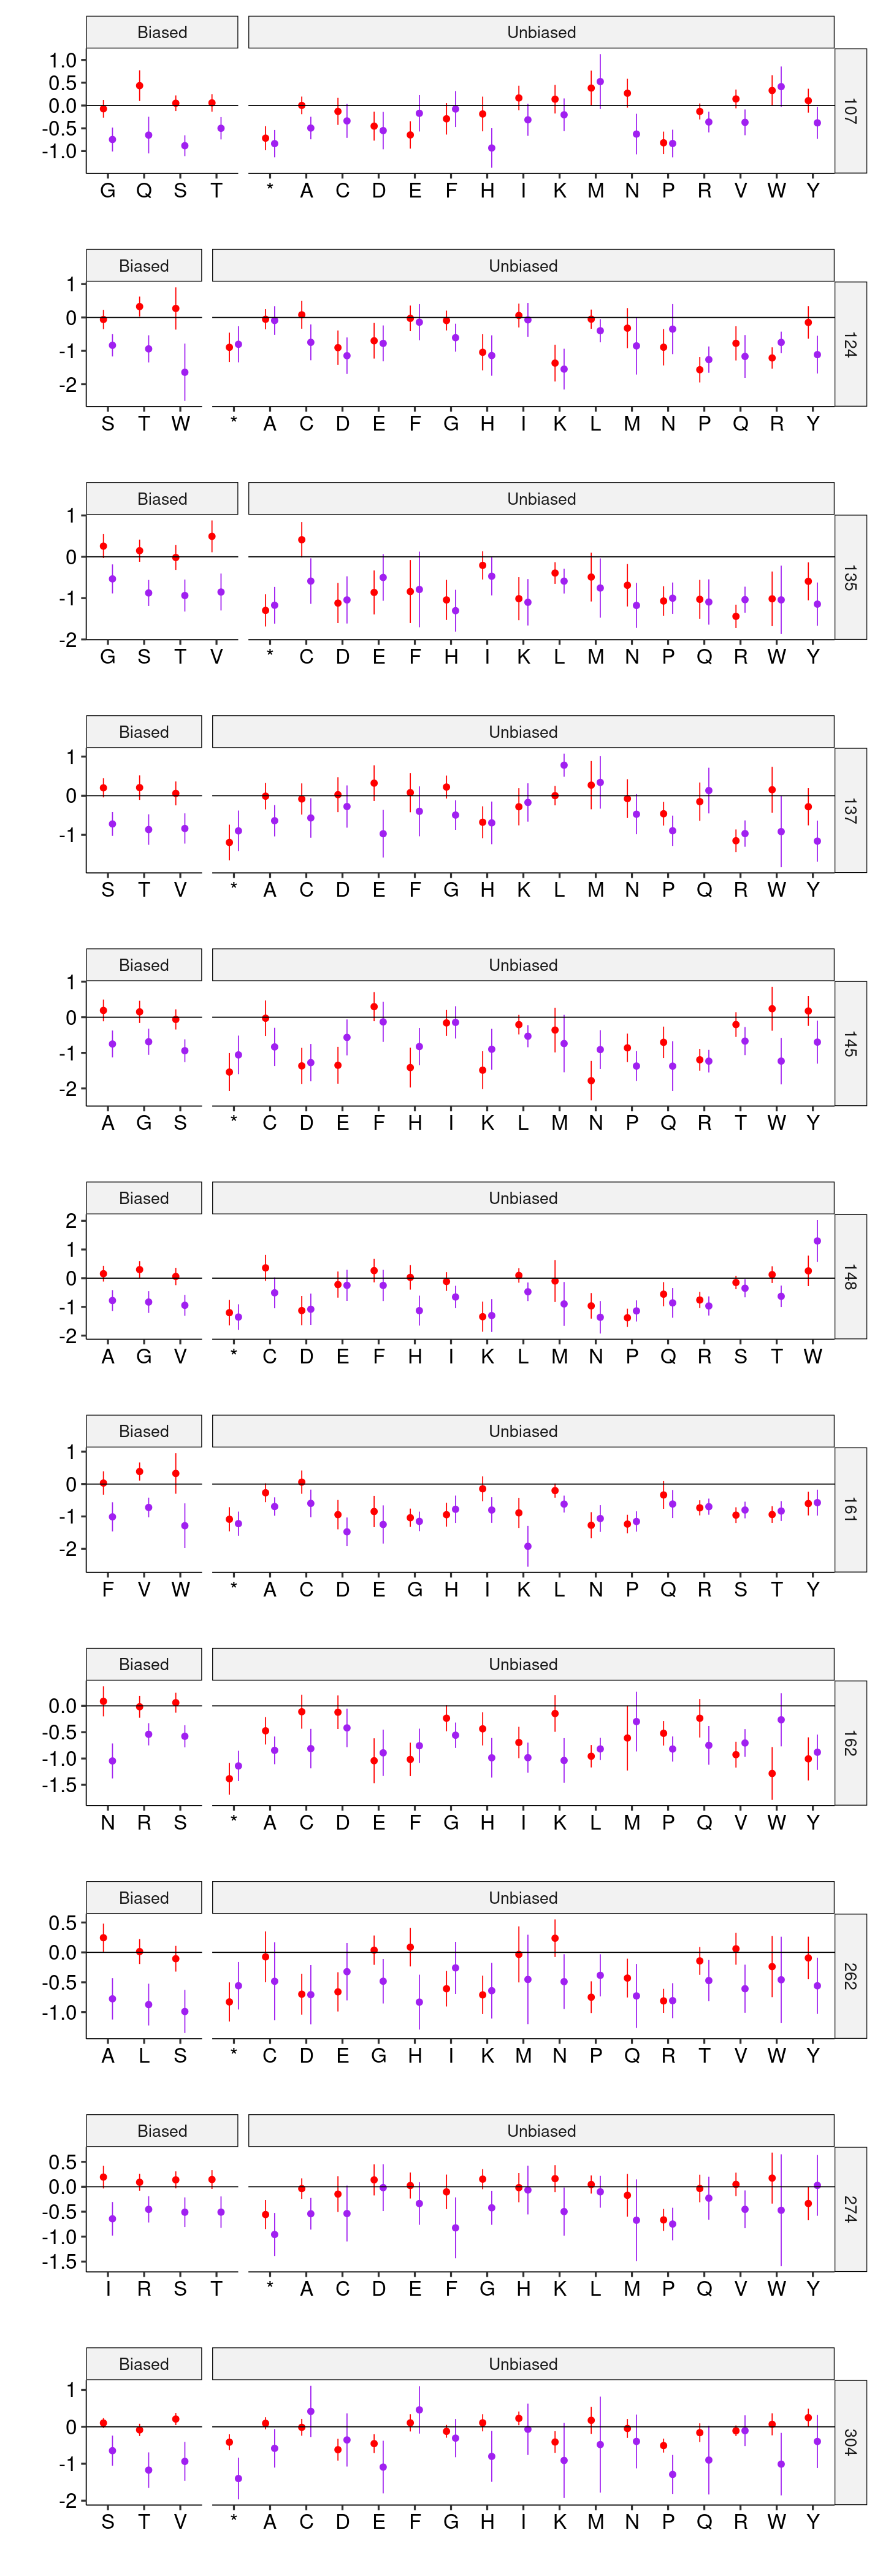

In [353]:
wrapped_summary <- wrap_plots(map(.f = plot_example, .x = sig_pos), ncol = 1)
ggsave("../dataviz/MC4R/MC4R-Bias-Subset.pdf", wrapped_summary, width = 12, height = 35)
wrapped_summary